# Initial model tuning and feature search

In [1]:
#imports
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import feature_selection
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, accuracy_score, precision_score
import pickle


In [2]:
%matplotlib inline
sns.set_palette("Set2")

In [3]:
#load initial cleaned data
df=pd.read_csv(r"..\data\processed\prelim_clean.csv", index_col=[0])

## drop some more
num of of visits and who referred

In [4]:
df

,NACCAVST,NACCNVST,NACCREFR,BIRTHYR,HISPANIC,HISPOR,RACE,RACESEC,RACETER,PRIMLANG,...,NACCTCSF,NACCMRSA,NACCNMRI,NACCAPSA,NACCNAPA,NACCAPOE,NACCNE4S,visit_interval,target,drug_count
0,4,2,2,1920,0,88,5,88,88,1,...,0,0,0,0,0,1,0,427.0,1.0,5
1,2,2,2,1939,0,88,1,88,88,1,...,0,0,0,0,0,2,1,474.0,1.0,4
2,6,6,8,1932,0,88,5,88,88,3,...,0,0,0,0,0,1,0,413.0,1.0,7
4,3,3,2,1935,0,88,1,88,88,1,...,0,0,0,0,0,1,0,327.0,1.0,8
5,5,4,2,1935,0,88,1,88,88,1,...,0,0,0,0,0,2,1,264.0,1.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18759,3,3,1,1921,0,88,1,88,88,1,...,0,0,0,0,0,9,9,370.0,0.0,9
18761,2,2,8,1951,0,88,1,88,88,1,...,0,1,1,0,0,2,1,723.0,0.0,5
18764,7,4,1,1930,0,88,1,88,88,1,...,0,0,0,0,0,1,0,351.0,0.0,3
18767,9,9,8,1928,0,88,1,88,88,1,...,0,0,0,0,0,1,0,315.0,0.0,7


In [5]:
df.drop(['NACCNVST','NACCAVST','NACCREFR'],inplace=True,axis=1)

##split dataset

In [6]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['target'], axis=1), df['target'], test_size=0.35, random_state=1)

If we predict that everything is 0 (no AD) what's the result?

In [7]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
y_pred=dummy_clf.predict(X_test)
print(dummy_clf.score(X_test, y_test))
print(precision_score(y_test,y_pred, labels=np.unique(y_pred)))
recall_score(y_test,y_pred)


0.5916473317865429
0.0


C:\Users\viceva\miniconda3\envs\AD\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.0

If we predict everything randomly, what do we get?

In [8]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="uniform")
dummy_clf.fit(X_train, y_train)
y_pred=dummy_clf.predict(X_test)
print(dummy_clf.score(X_test, y_test))
print(precision_score(y_test,y_pred, labels=np.unique(y_pred)))
recall_score(y_test,y_pred)

0.5104408352668214
0.4033989266547406


0.5125

If we predict randomly taking into account inbalances

In [9]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(X_train, y_train)
y_pred=dummy_clf.predict(X_test)
print(dummy_clf.score(X_test, y_test))
print(precision_score(y_test,y_pred, labels=np.unique(y_pred)))
recall_score(y_test,y_pred)

0.525754060324826
0.4152744630071599


0.39545454545454545

# Untunned
## Initialize forest baseline

In [10]:
model = RandomForestClassifier()
#train model
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(model.score(X_test, y_test))
print(precision_score(y_test,y_pred))
recall_score(y_test,y_pred)

0.7531322505800464
0.7514450867052023


0.5909090909090909

## first pass at the features

In [11]:
#take 10% of original dataframe to start with, but the forest takes only sqrt
print(df.shape[1]*.1)
print(np.sqrt(df.shape[1]))

55.6
23.57965224510319


[(0.0221, 'NEWINF'), (0.0201, 'MEMUNITS'), (0.0154, 'CDRSUM'), (0.0145, 'LOGIMEM'), (0.0112, 'NACCBMI'), (0.0111, 'WEIGHT'), (0.0111, 'VEG'), (0.011, 'visit_interval'), (0.0109, 'INBIRYR'), (0.0107, 'BIRTHYR'), (0.0106, 'ORIENT'), (0.0105, 'TRAILA'), (0.0104, 'ANIMALS'), (0.0103, 'NACCAGEB'), (0.0102, 'NACCADMD'), (0.0102, 'DECAGE'), (0.01, 'TRAILB'), (0.0098, 'NACCAGE'), (0.0098, 'BPSYS'), (0.0097, 'NACCAM'), (0.0095, 'WAIS'), (0.0088, 'HRATE'), (0.0086, 'NACCMMSE'), (0.0086, 'BPDIAS'), (0.0084, 'HEIGHT'), (0.0083, 'MEMTIME'), (0.0076, 'NACCAMD'), (0.0074, 'drug_count'), (0.0074, 'EDUC'), (0.0073, 'REMDATES'), (0.007, 'HOMEHOBB'), (0.0068, 'TAXES'), (0.0064, 'BOSTON'), (0.0061, 'DIGIF'), (0.0059, 'SMOKYRS'), (0.0059, 'QUITSMOK'), (0.0059, 'MEMORY'), (0.0059, 'CRAFTDRE'), (0.0055, 'UDSBENTD'), (0.0053, 'NACCMOCA'), (0.0052, 'TRAILBRR'), (0.0052, 'NAMNDEM'), (0.0051, 'NACCGDS'), (0.0051, 'DIGIB'), (0.005, 'MOCATOTS'), (0.005, 'DECIN'), (0.005, 'BILLS'), (0.0049, 'NACCAPOE'), (0.0048, 'P

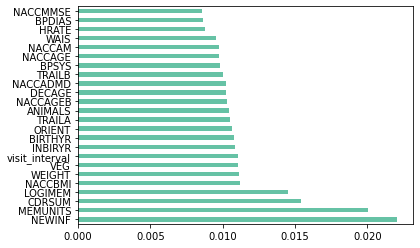

In [12]:
#Features sorted by their score
feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feat_importances.nlargest(24).plot(kind='barh')
cols=X_train.columns
print(sorted(zip(map(lambda x: round(x, 4), model.feature_importances_), cols), 
             reverse=True))

In [13]:
restrict=feat_importances.nlargest(56).index
res=df[restrict.to_list()]
X_train, X_test, y_train, y_test = train_test_split(res, df['target'], test_size=0.35, random_state=1)

In [14]:
model_feat1 = RandomForestClassifier()
#train model
model_feat1.fit(X_train, y_train)
y_pred = model_feat1.predict(X_test)
print(model_feat1.score(X_test, y_test))
print(precision_score(y_test,y_pred))
recall_score(y_test,y_pred)

0.7503480278422274
0.7394957983193278


0.6

In [15]:
restrict=feat_importances.nlargest(24).index
res=df[restrict.to_list()]
X_train, X_test, y_train, y_test = train_test_split(res, df['target'], test_size=0.35, random_state=1)

In [16]:
model_feat1 = RandomForestClassifier()
#train model
model_feat1.fit(X_train, y_train)
y_pred = model_feat1.predict(X_test)
print(model_feat1.score(X_test, y_test))
print(precision_score(y_test,y_pred))
recall_score(y_test,y_pred)

0.7164733178654292
0.6844993141289437


0.5670454545454545

In [17]:
restrict=feat_importances.nlargest(100).index
res=df[restrict.to_list()]
X_train, X_test, y_train, y_test = train_test_split(res, df['target'], test_size=0.35, random_state=1)

model_feat1 = RandomForestClassifier()
#train model
model_feat1.fit(X_train, y_train)
y_pred = model_feat1.predict(X_test)
print(model_feat1.score(X_test, y_test))
print(precision_score(y_test,y_pred))
recall_score(y_test,y_pred)

0.7554524361948955
0.7482419127988749


0.6045454545454545

### Exploring top 100 features

In [18]:
#normalized count function because libraries suck
def norm_count_single(df, column, target):
    c=column
    df1 = df.groupby(target)[c].value_counts(normalize=True)
    df1 = df1.rename('norm').reset_index()
    sns.barplot(x=c,y='norm',hue=target,data=df1)
    
def norm_count_group(df, target):    
    ix = 1
    fig = plt.figure(figsize = (15,10))
    for c in list(df.columns):
        if ix <= 3:
            if c != target:
                ax1 = fig.add_subplot(1,3,ix)
                df1 = df.groupby(target)[c].value_counts(normalize=True)
                df1 = df1.rename('norm').reset_index()
                sns.barplot(x=c,y='norm',hue=target,data=df1,ax = ax1)
                plt.xticks(rotation=45)

        ix = ix +1
        if ix == 4: 
            fig = plt.figure(figsize = (15,10))
            ix =1

C:\Users\viceva\miniconda3\envs\AD\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


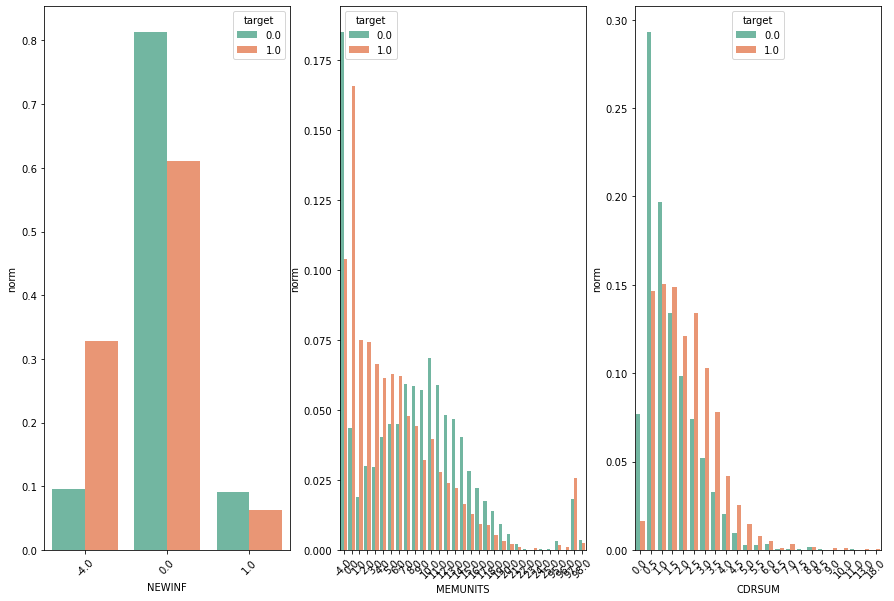

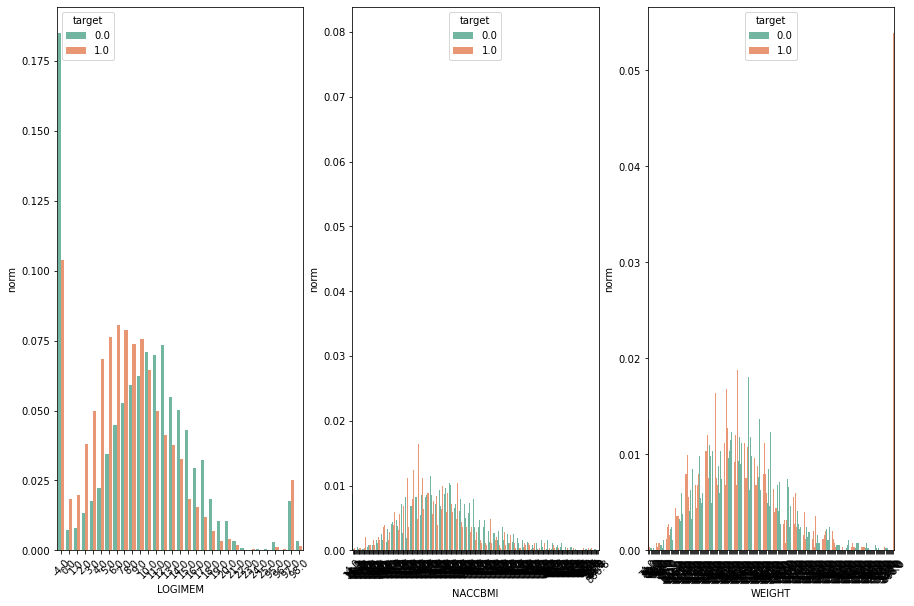

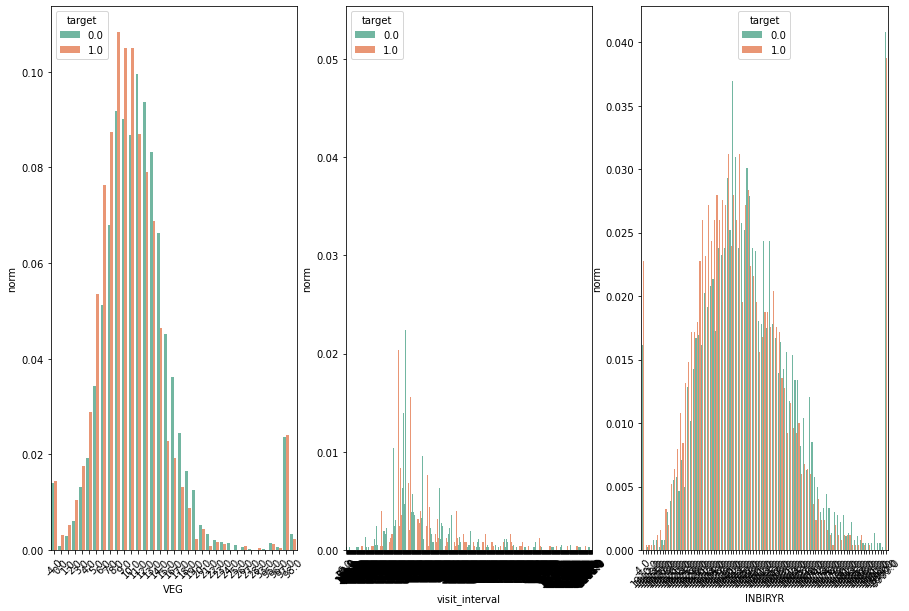

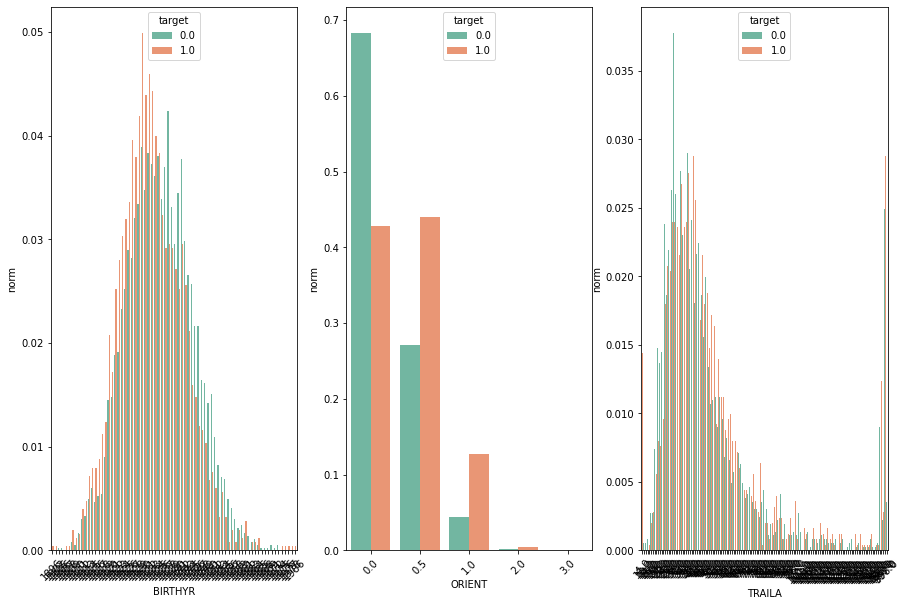

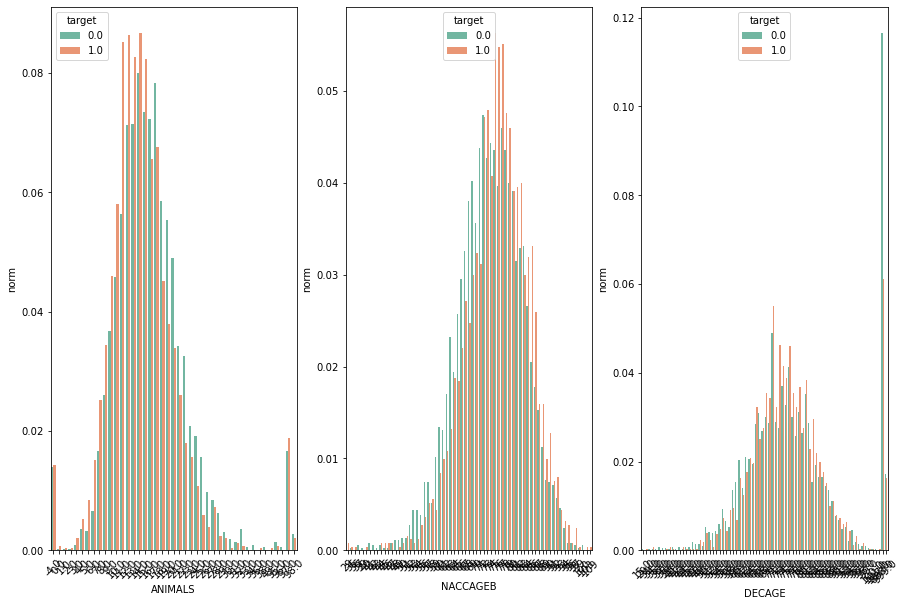

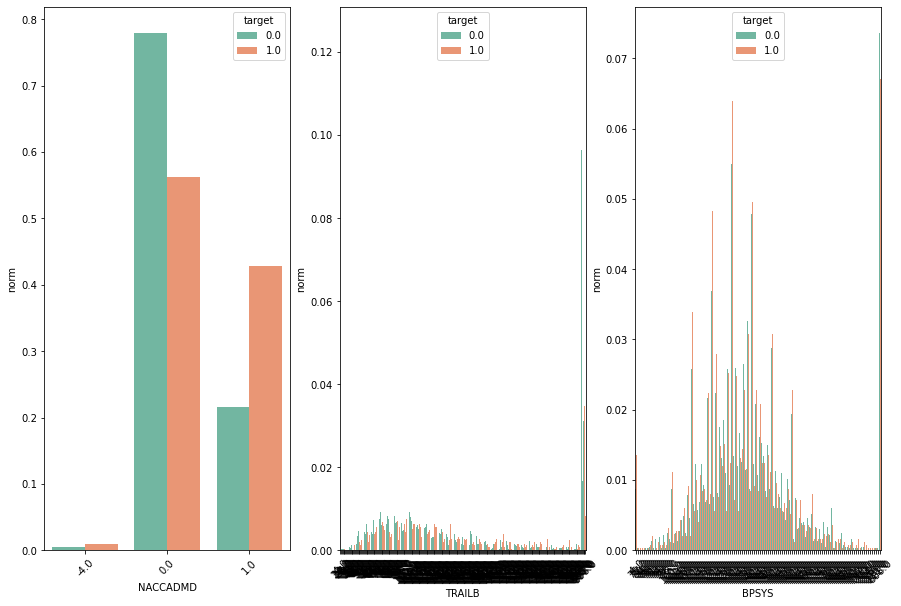

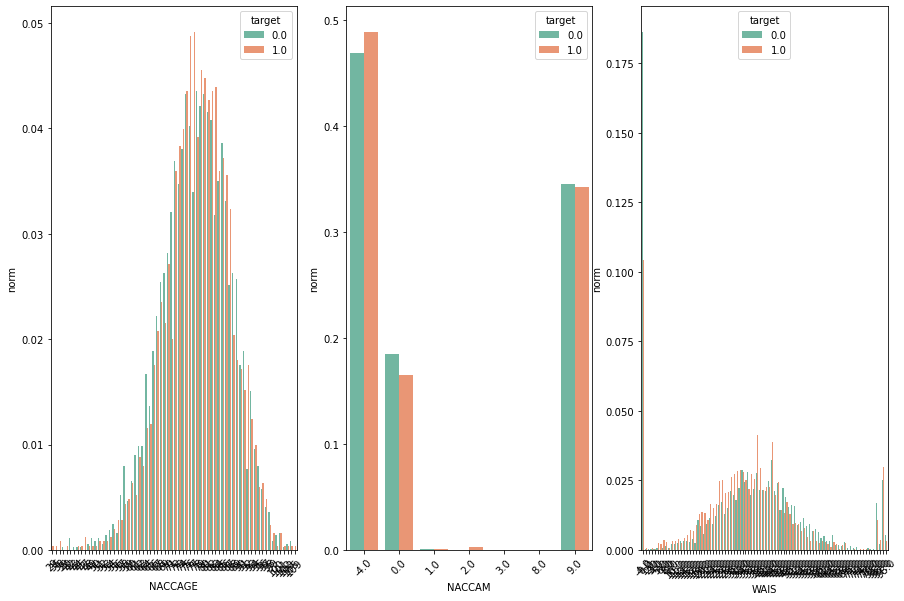

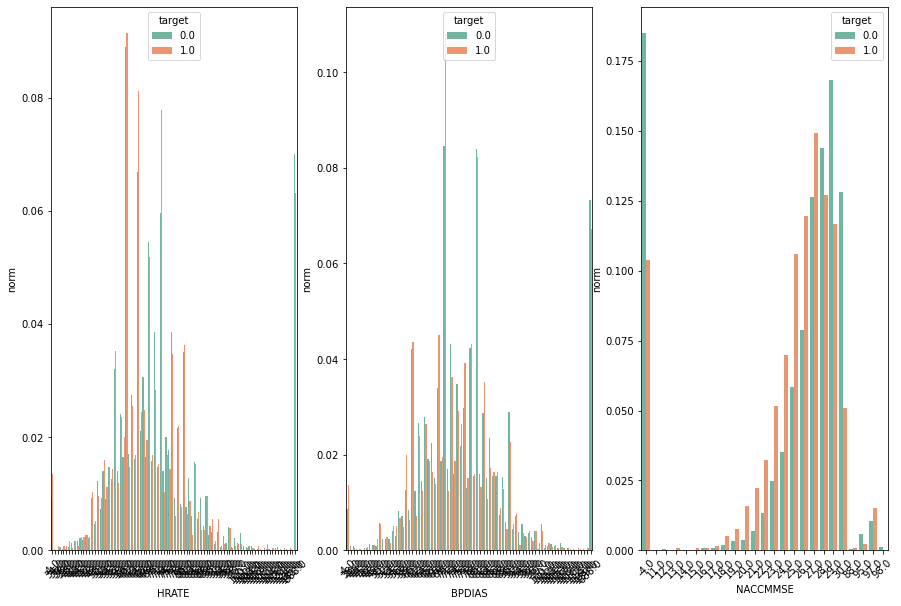

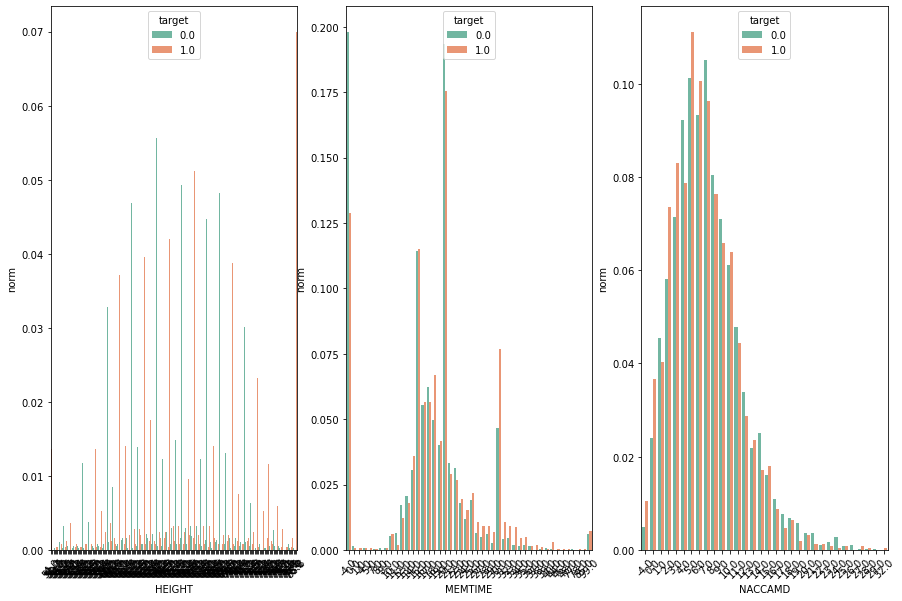

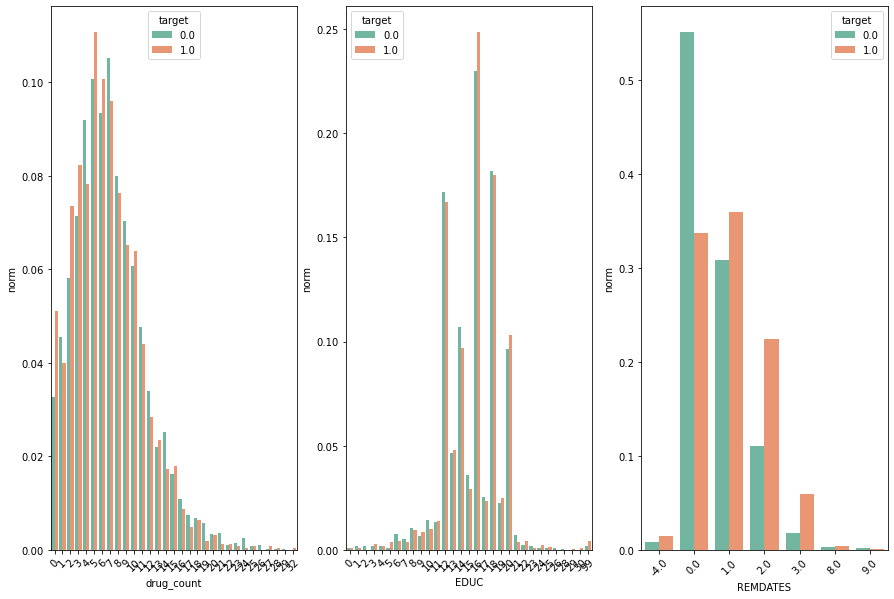

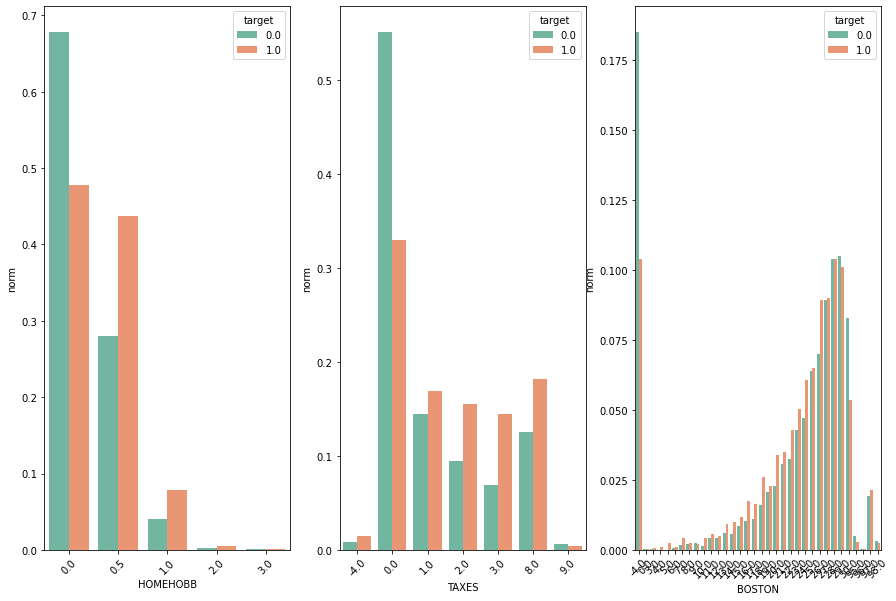

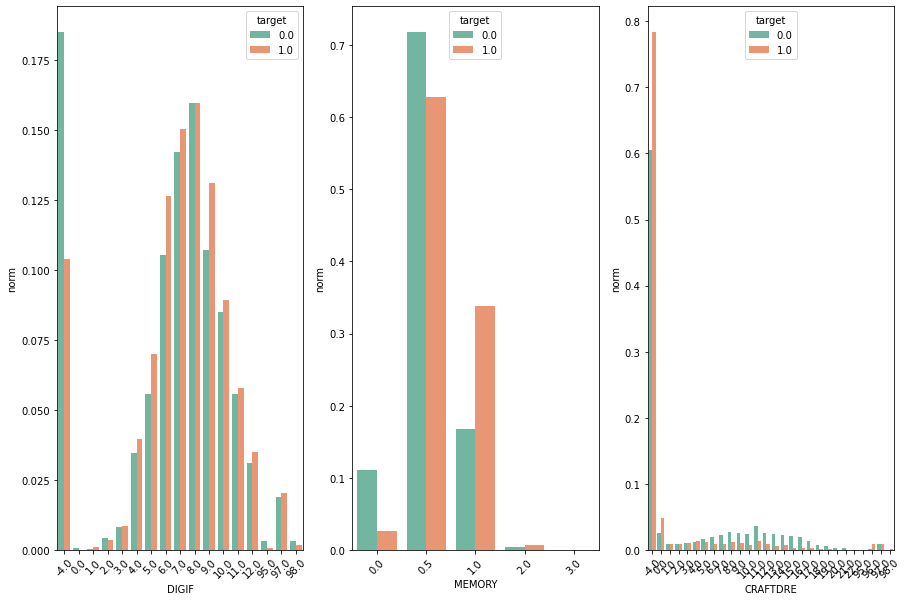

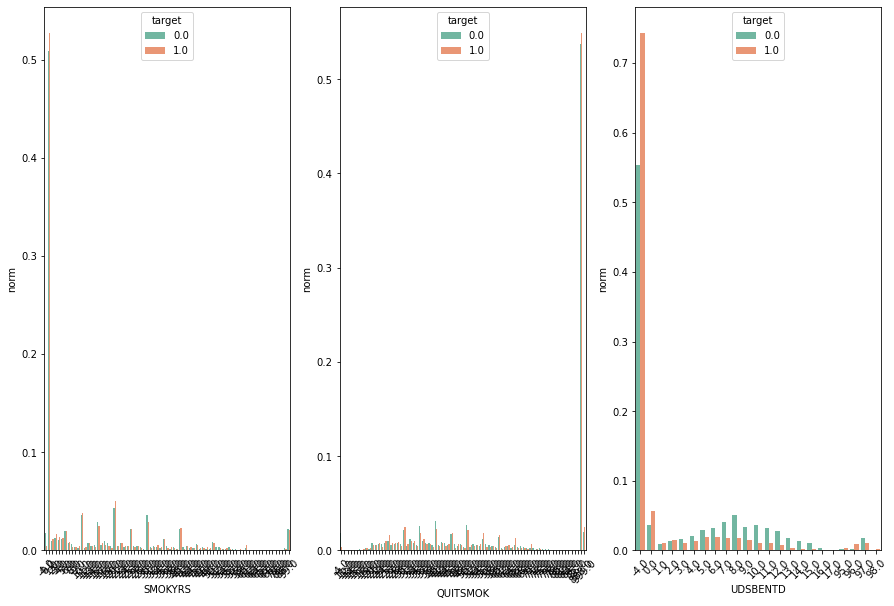

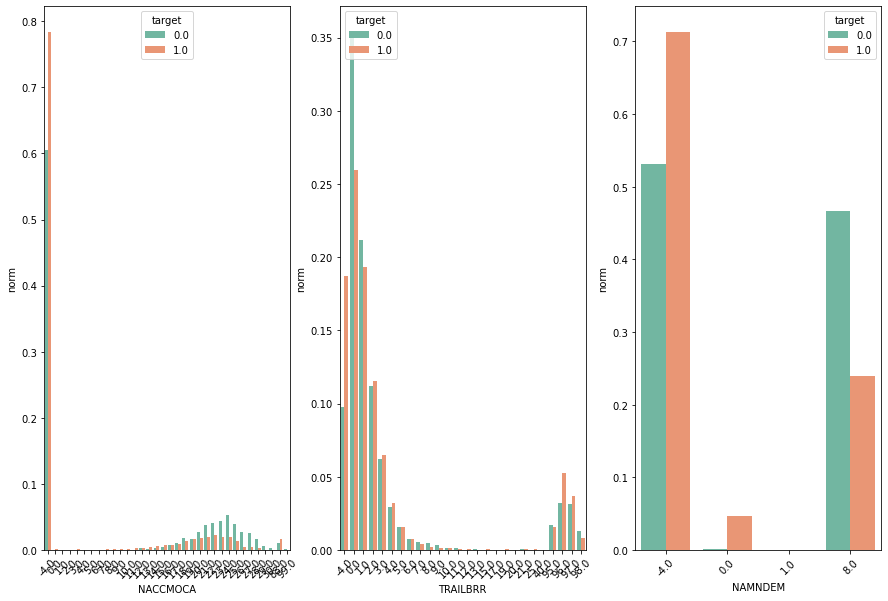

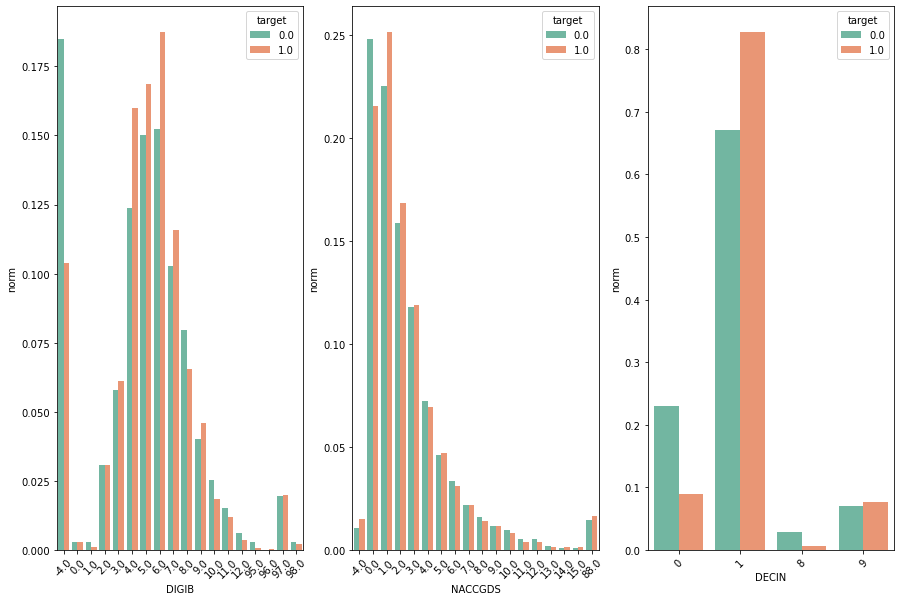

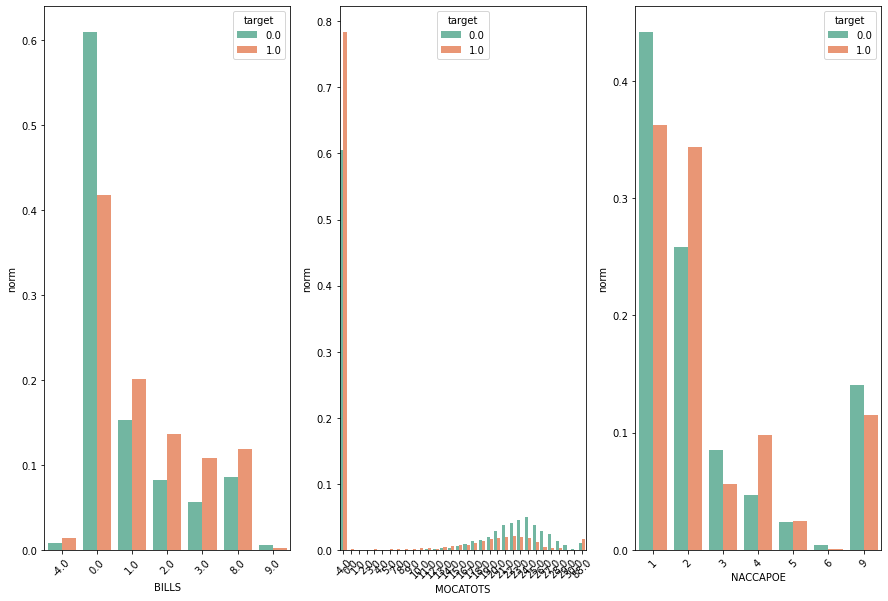

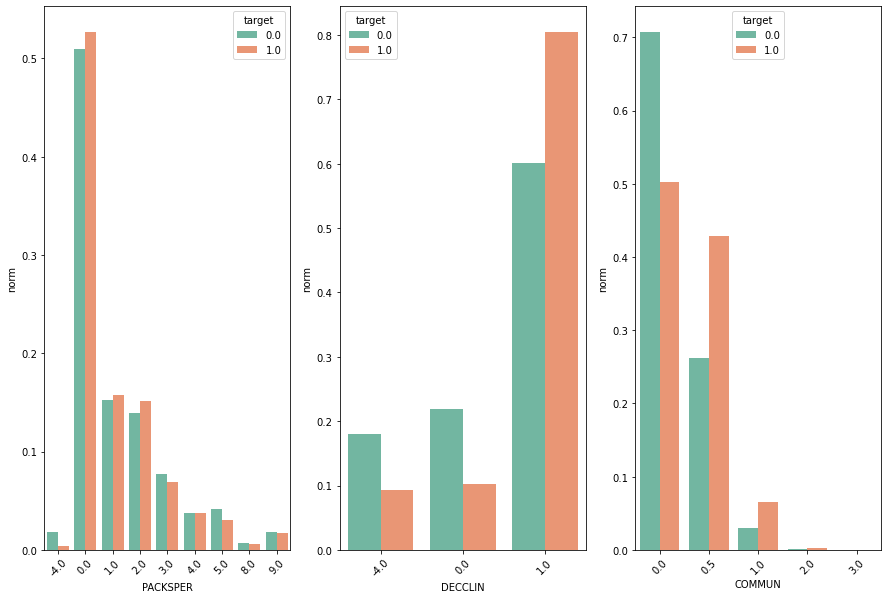

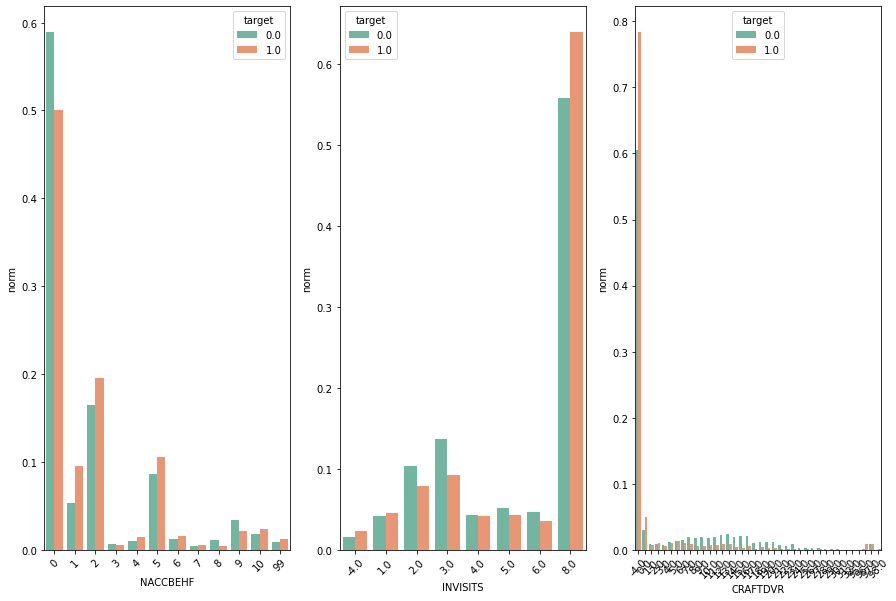

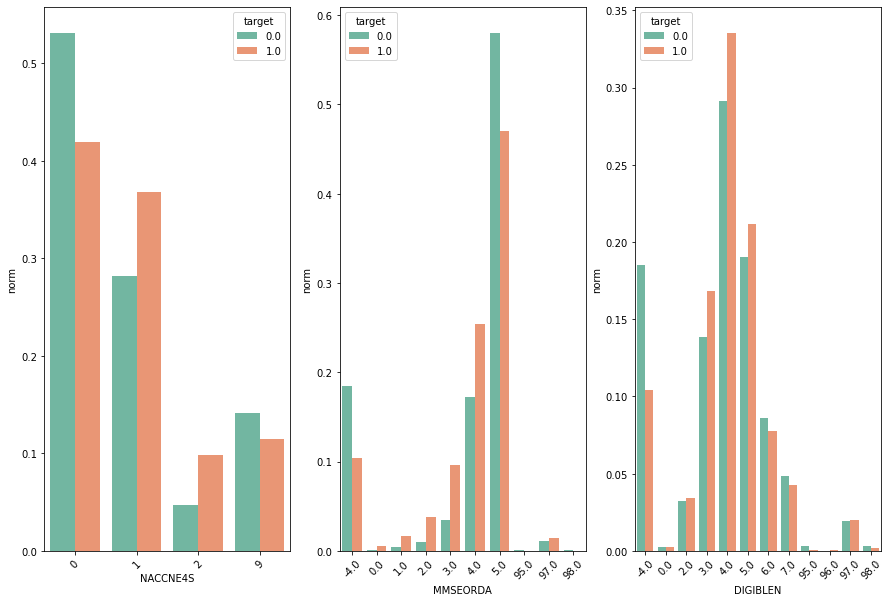

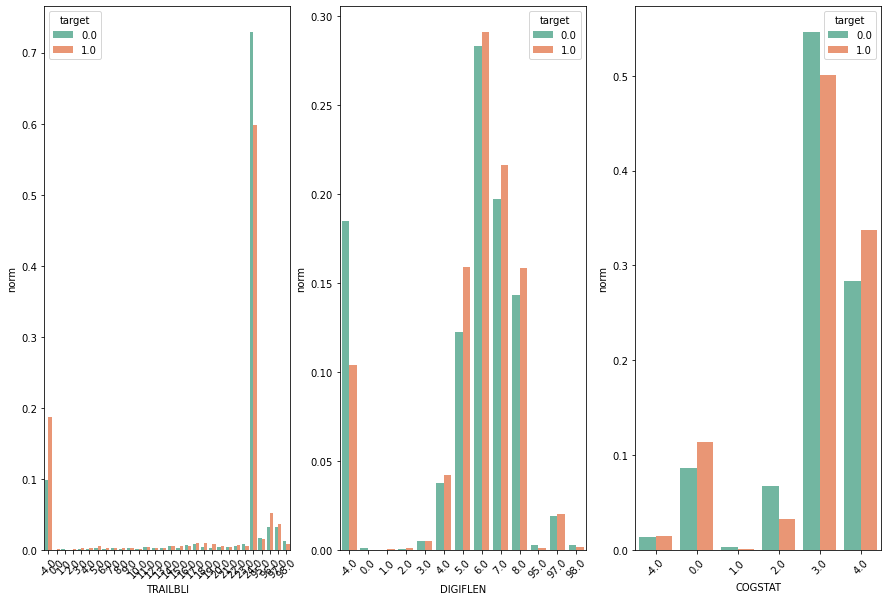

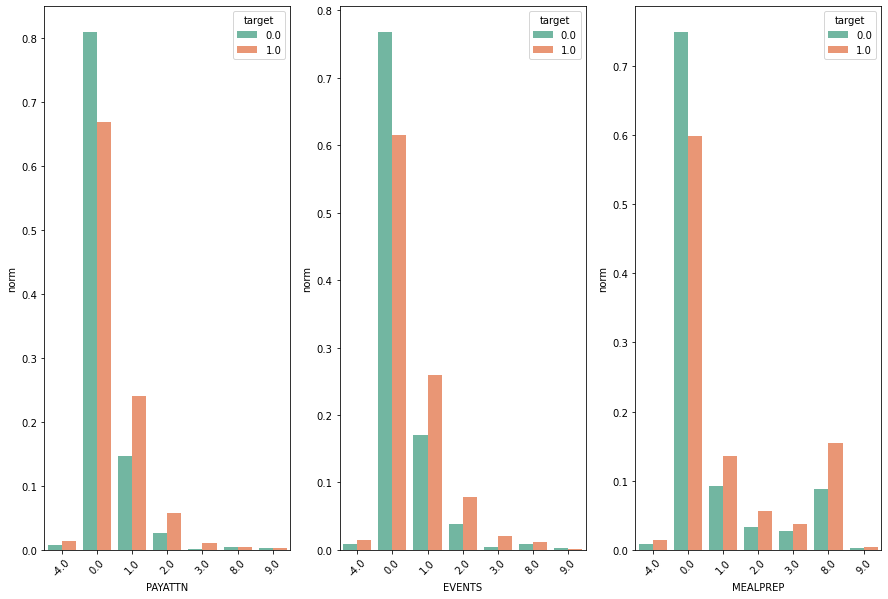

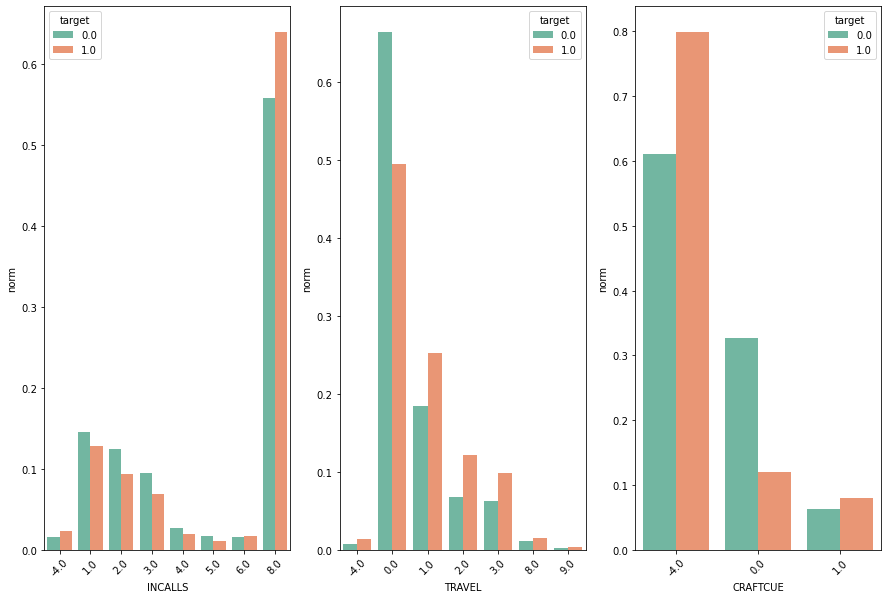

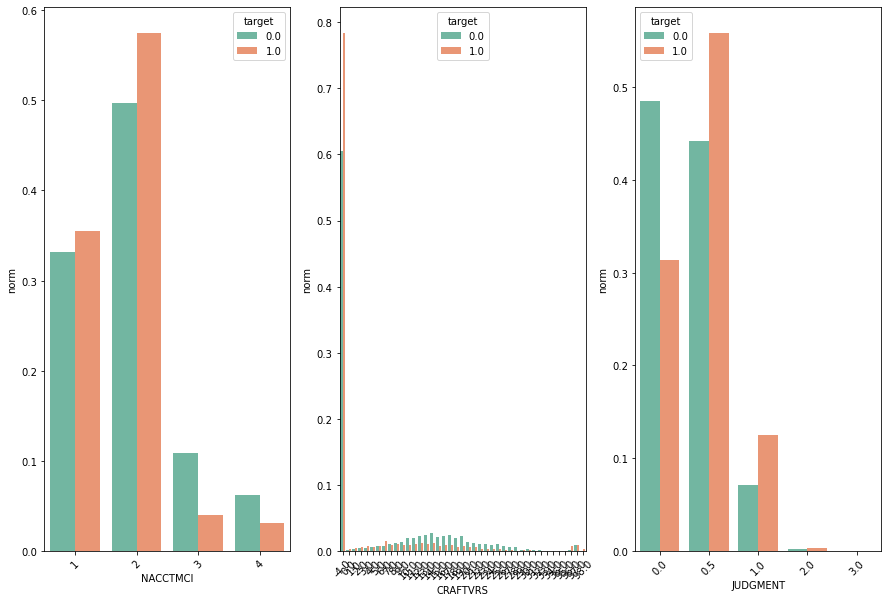

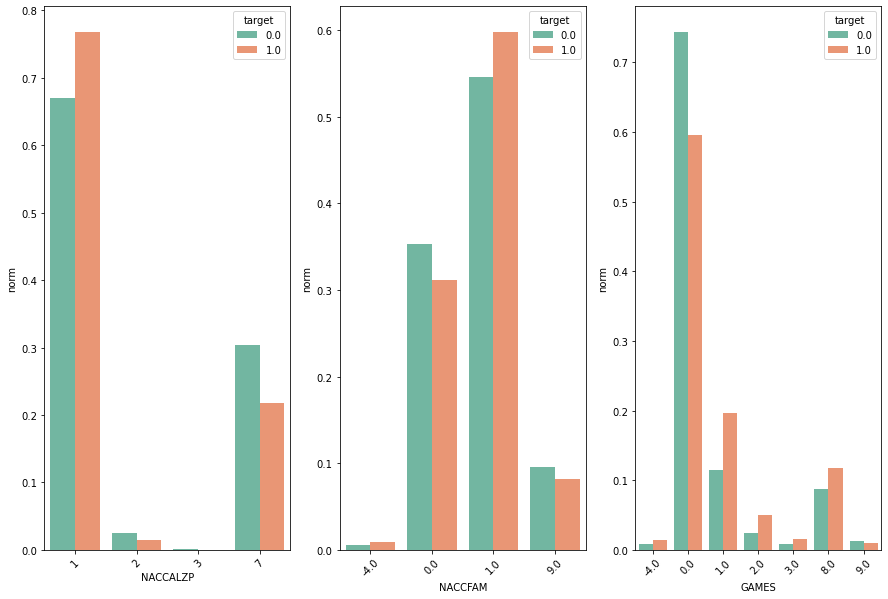

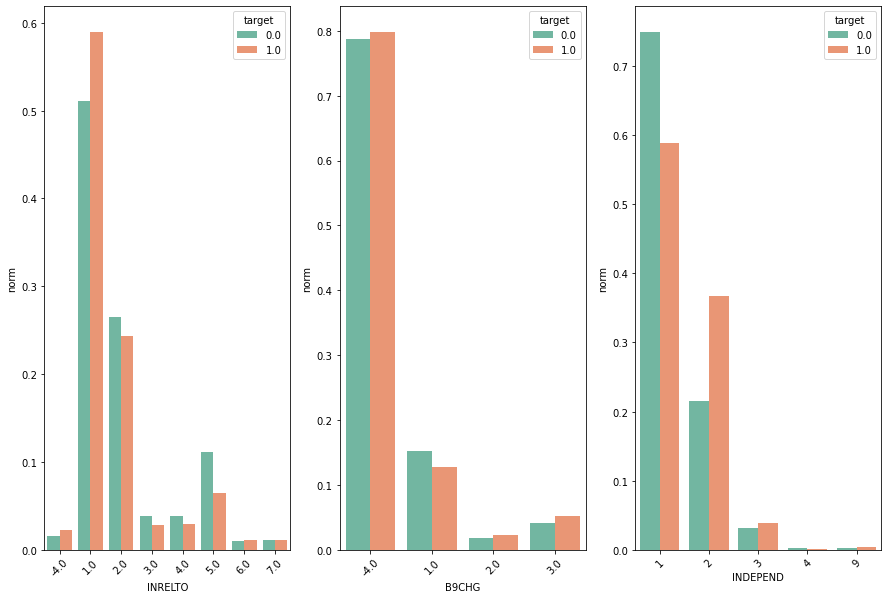

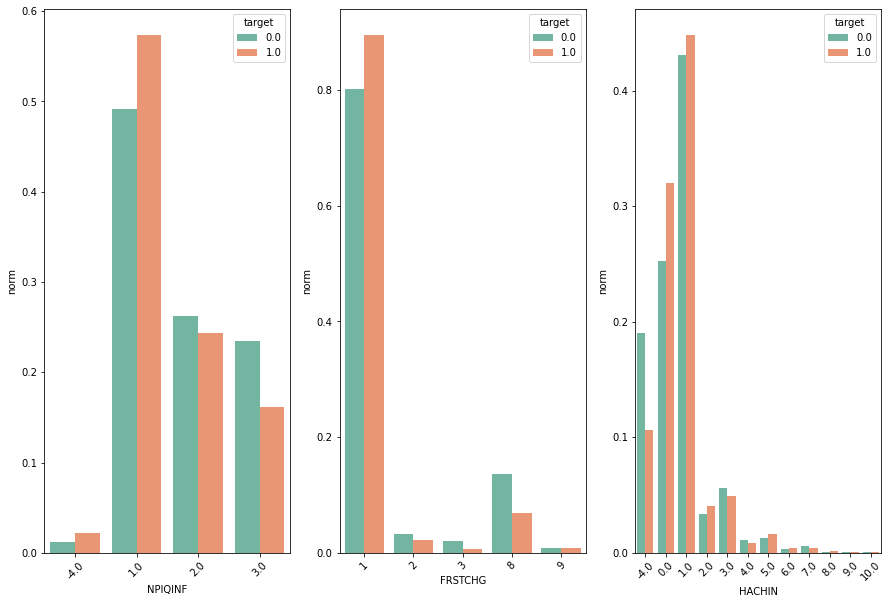

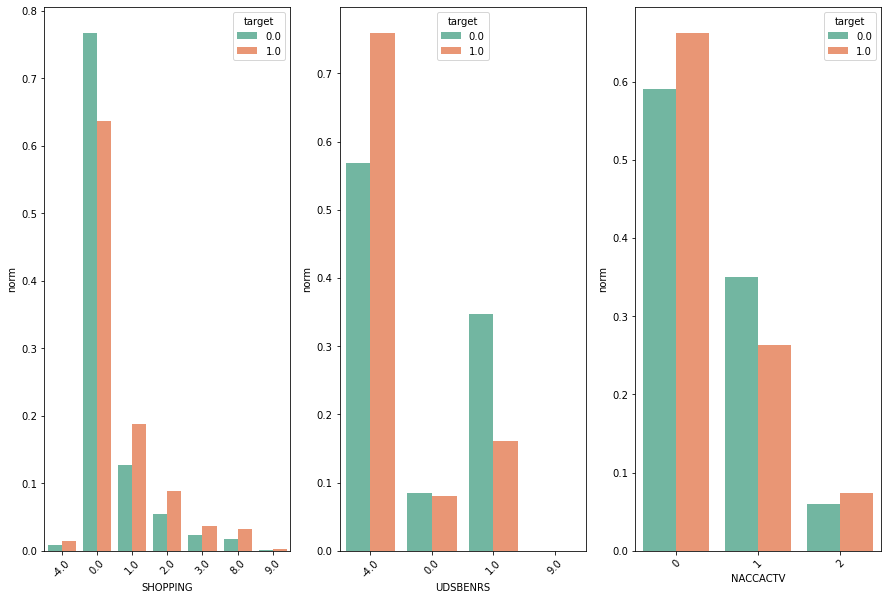

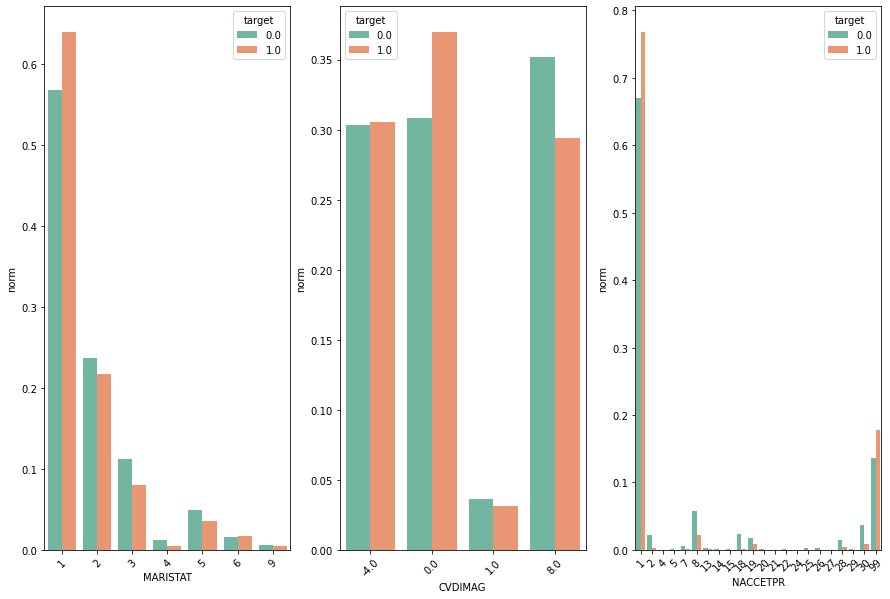

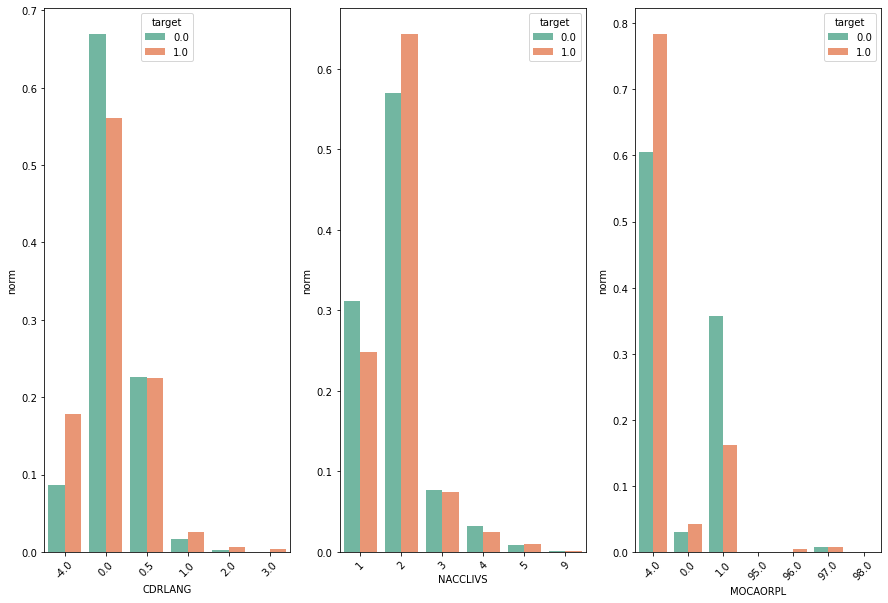

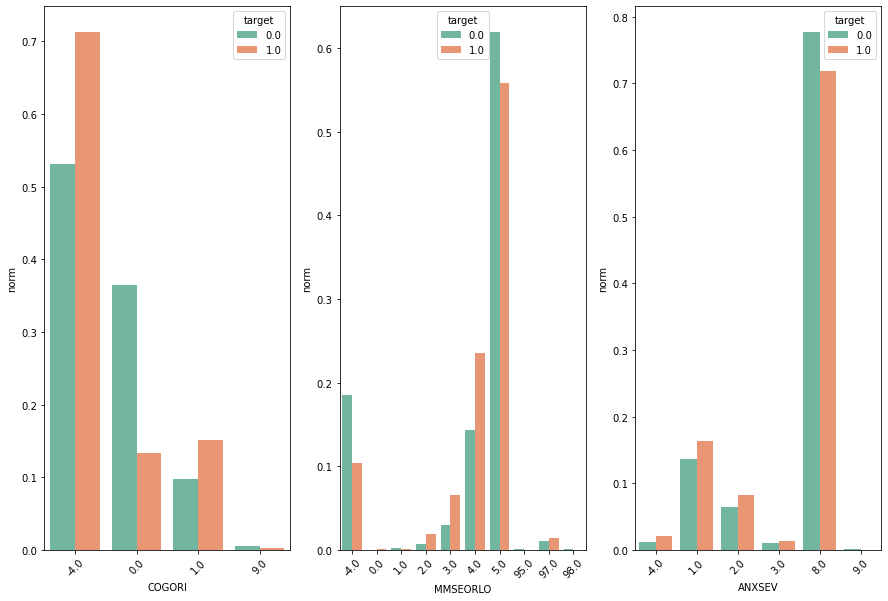

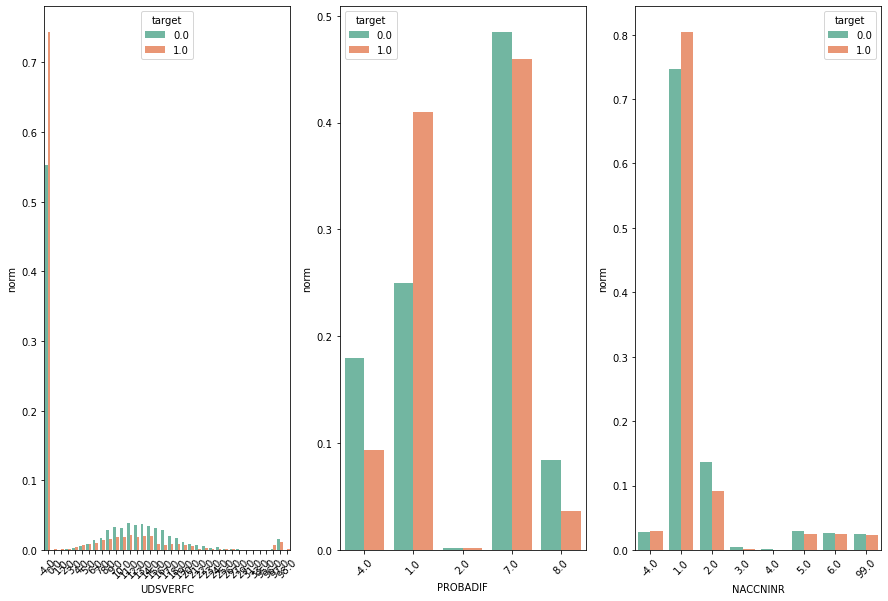

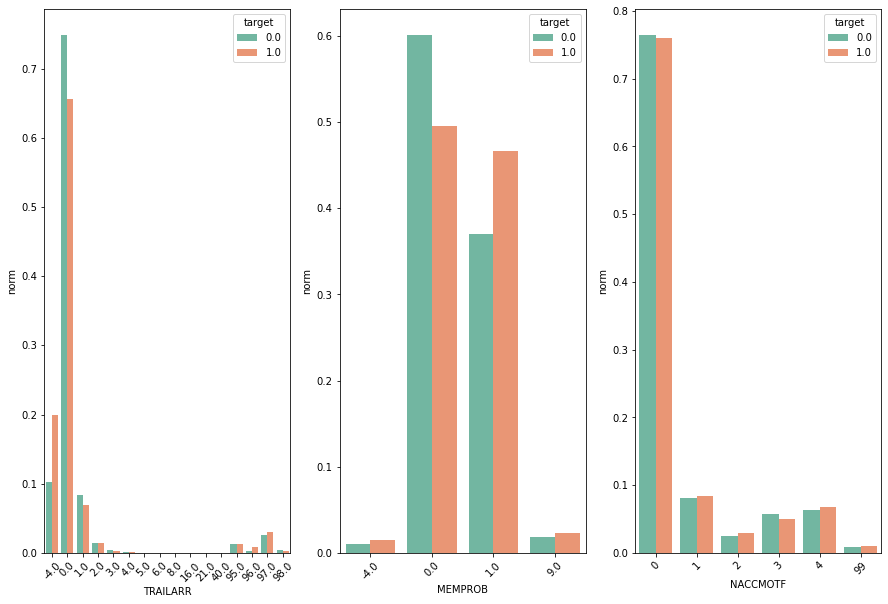

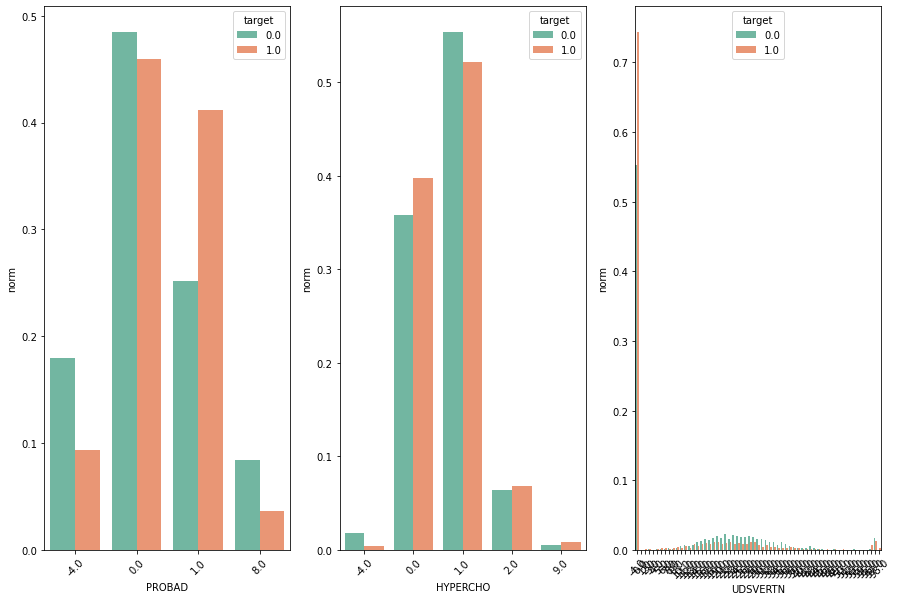

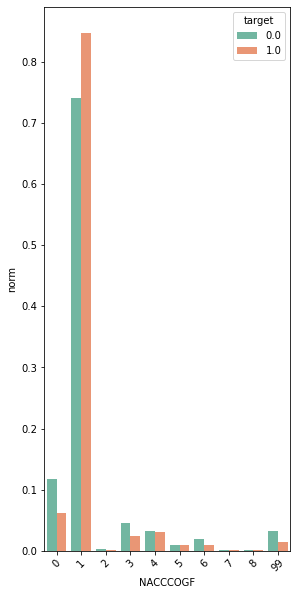

In [19]:
temp=res.copy()
temp['target']=df['target']
norm_count_group(temp,'target')

Let's do some tests without coparticipant

0.7382830626450116
0.7276657060518732
0.5738636363636364


<AxesSubplot:>

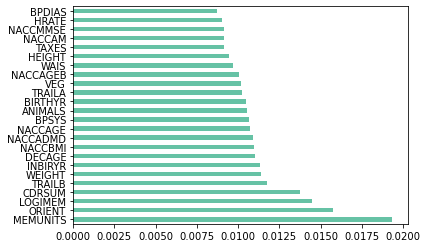

In [20]:
res=df.drop(['NEWINF','target','visit_interval'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(res, df['target'], test_size=0.35, random_state=1)

model_feat1 = RandomForestClassifier()
#train model
model_feat1.fit(X_train, y_train)
y_pred = model_feat1.predict(X_test)
print(model_feat1.score(X_test, y_test))
print(precision_score(y_test,y_pred))
print(recall_score(y_test,y_pred))


#Features sorted by their score
feat_importances = pd.Series(model_feat1.feature_importances_, index=X_train.columns)
feat_importances.nlargest(24).plot(kind='barh')

Precision is lower but overall works fine

What's the performance if we drop tests that have >50% null

In [21]:
restricted = df.loc[:,~df.eq(-4).sum().gt(len(df)/2)]
restricted

,BIRTHYR,HISPANIC,HISPOR,RACE,RACESEC,RACETER,PRIMLANG,EDUC,MARISTAT,NACCLIVS,...,NACCTCSF,NACCMRSA,NACCNMRI,NACCAPSA,NACCNAPA,NACCAPOE,NACCNE4S,visit_interval,target,drug_count
0,1920,0,88,5,88,88,1,15,1,2,...,0,0,0,0,0,1,0,427.0,1.0,5
1,1939,0,88,1,88,88,1,16,1,2,...,0,0,0,0,0,2,1,474.0,1.0,4
2,1932,0,88,5,88,88,3,20,1,2,...,0,0,0,0,0,1,0,413.0,1.0,7
4,1935,0,88,1,88,88,1,24,2,1,...,0,0,0,0,0,1,0,327.0,1.0,8
5,1935,0,88,1,88,88,1,20,2,1,...,0,0,0,0,0,2,1,264.0,1.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18759,1921,0,88,1,88,88,1,12,1,2,...,0,0,0,0,0,9,9,370.0,0.0,9
18761,1951,0,88,1,88,88,1,16,1,2,...,0,1,1,0,0,2,1,723.0,0.0,5
18764,1930,0,88,1,88,88,1,16,1,3,...,0,0,0,0,0,1,0,351.0,0.0,3
18767,1928,0,88,1,88,88,1,16,1,2,...,0,0,0,0,0,1,0,315.0,0.0,7


Initial model without coparticipants & visit interval, + dropped nan columns

0.7294663573085847
0.728110599078341
0.5386363636363637


<AxesSubplot:>

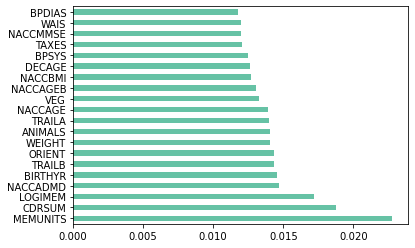

In [22]:
res=restricted.drop(['NEWINF','target','visit_interval','INBIRYR','HEIGHT'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(res, df['target'], test_size=0.35, random_state=1)

model_feat1 = RandomForestClassifier()
#train model
model_feat1.fit(X_train, y_train)
y_pred = model_feat1.predict(X_test)
print(model_feat1.score(X_test, y_test))
print(precision_score(y_test,y_pred))
print(recall_score(y_test,y_pred))


#Features sorted by their score
feat_importances = pd.Series(model_feat1.feature_importances_, index=X_train.columns)
feat_importances.nlargest(20).plot(kind='barh')

C:\Users\viceva\miniconda3\envs\AD\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


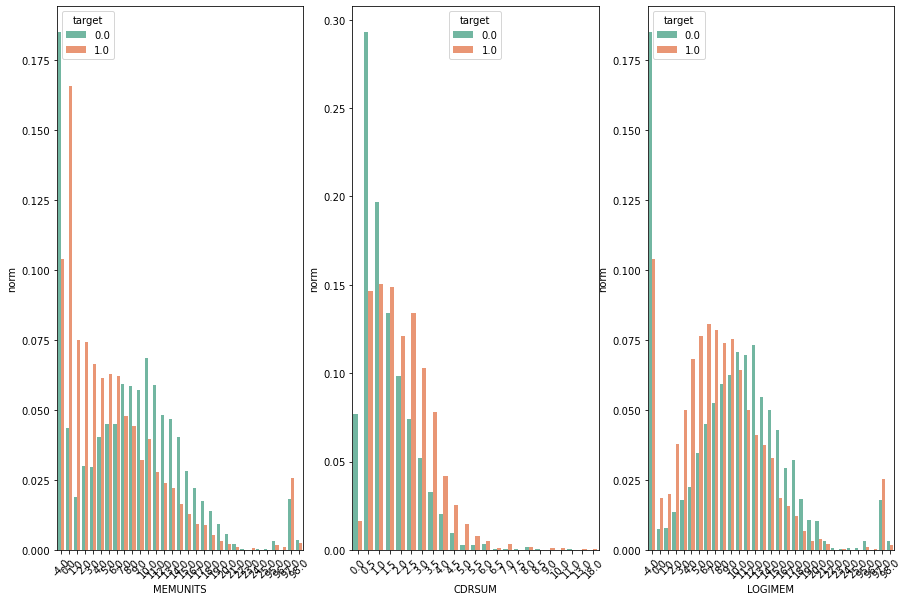

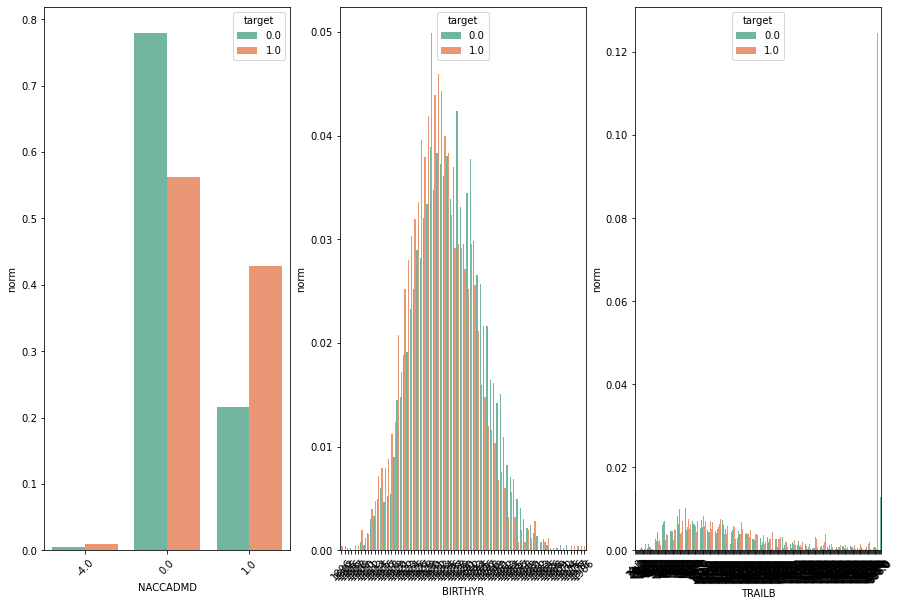

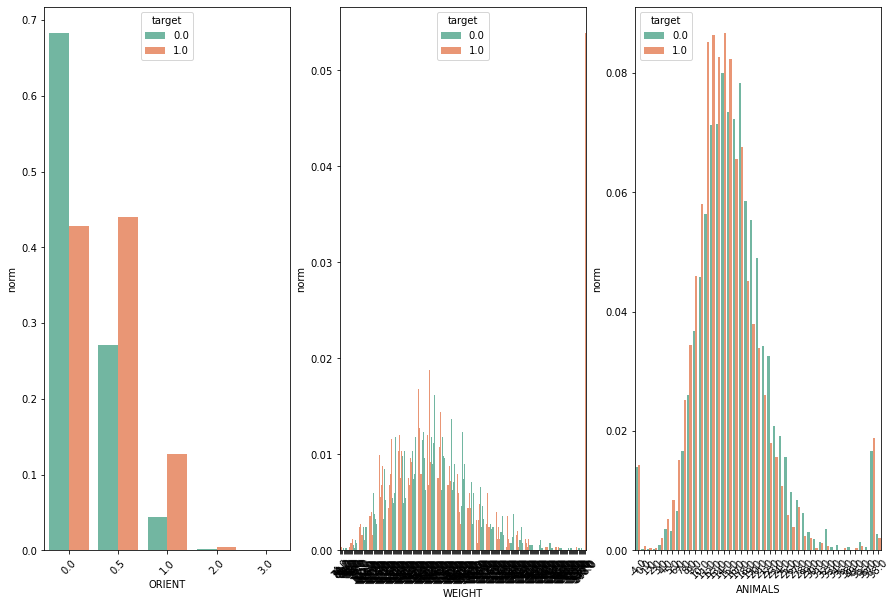

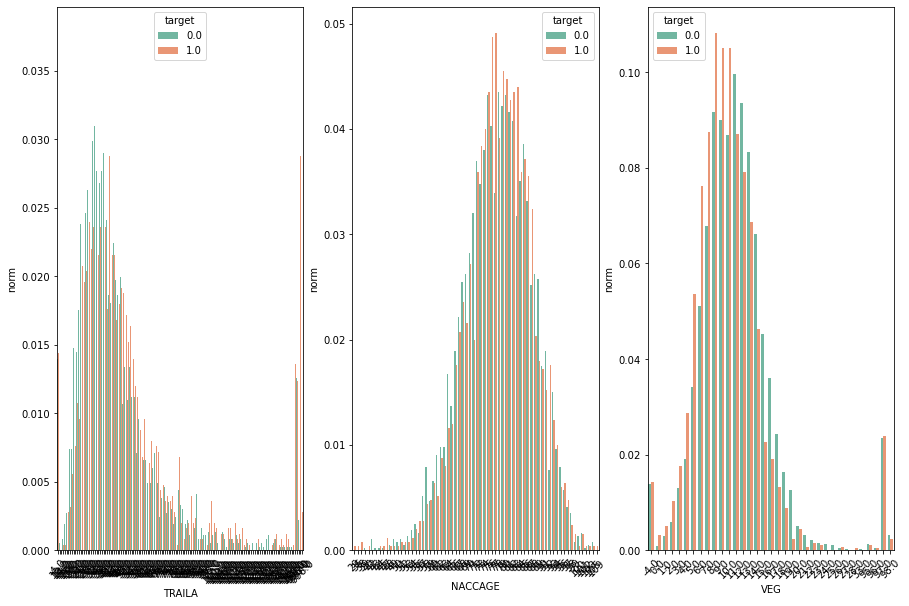

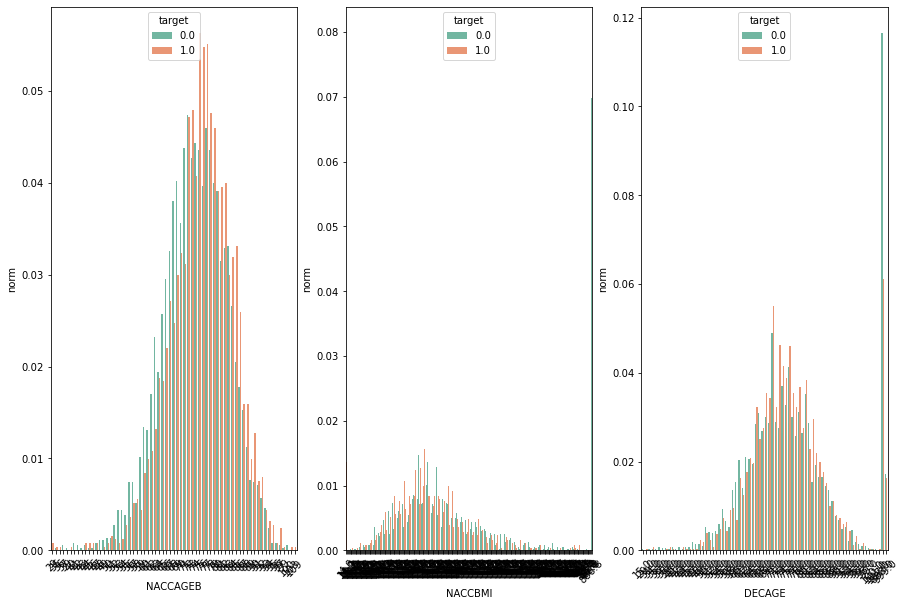

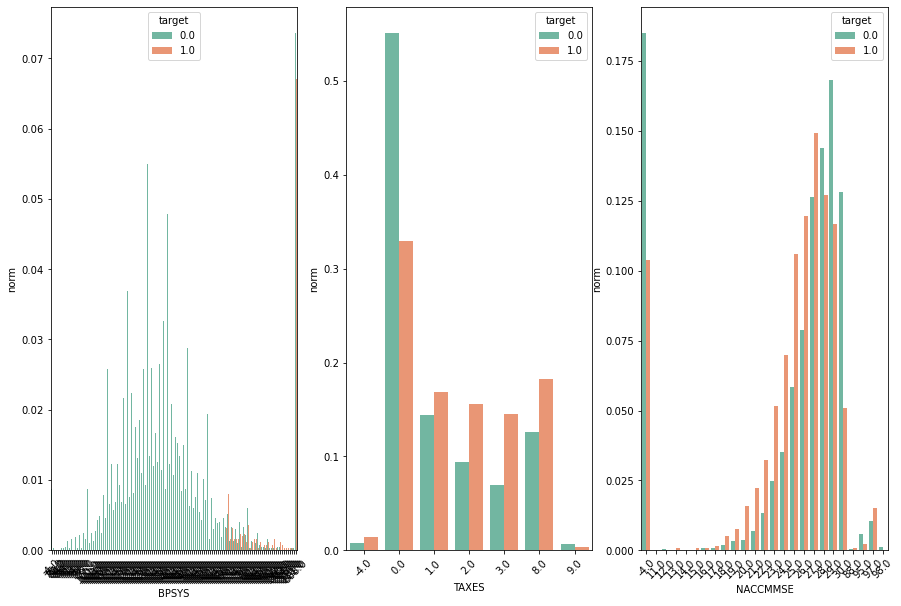

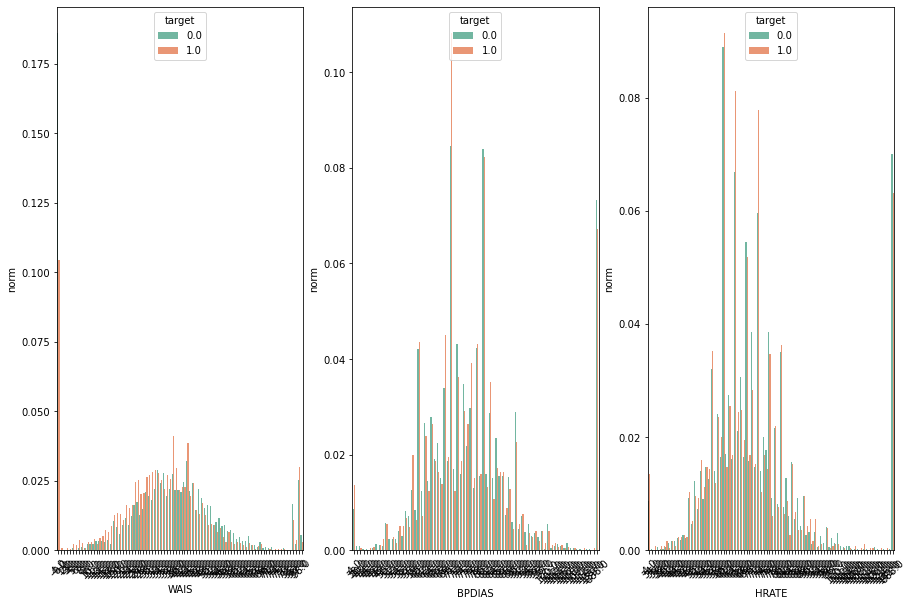

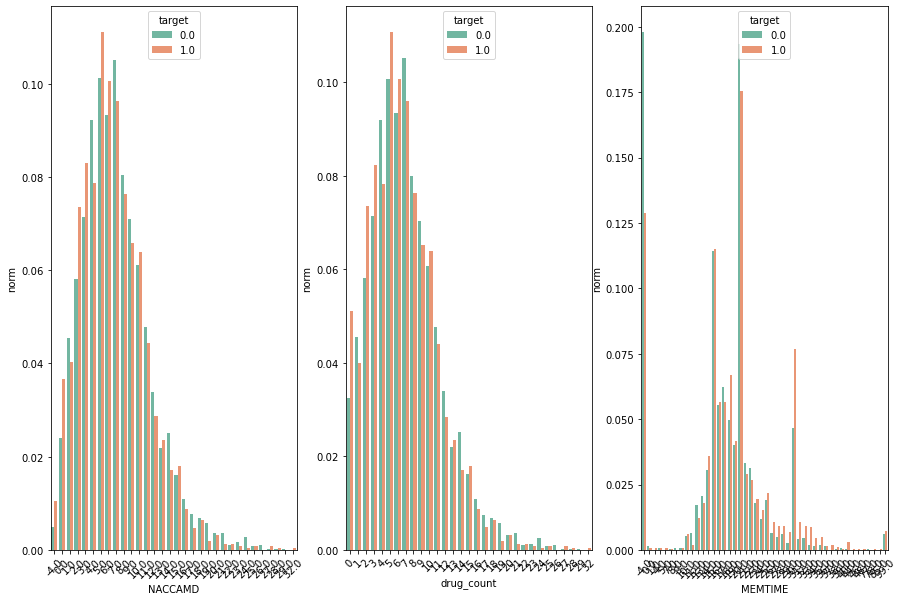

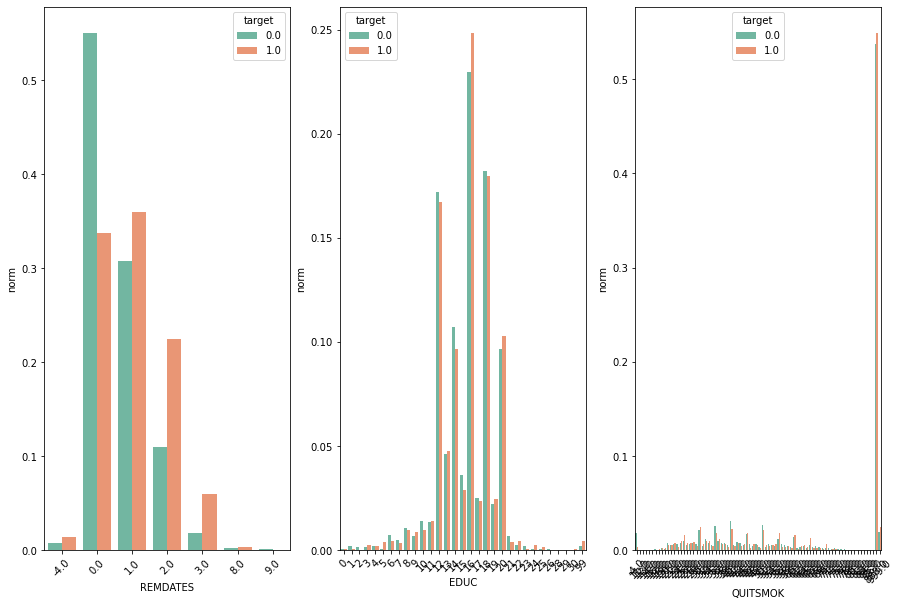

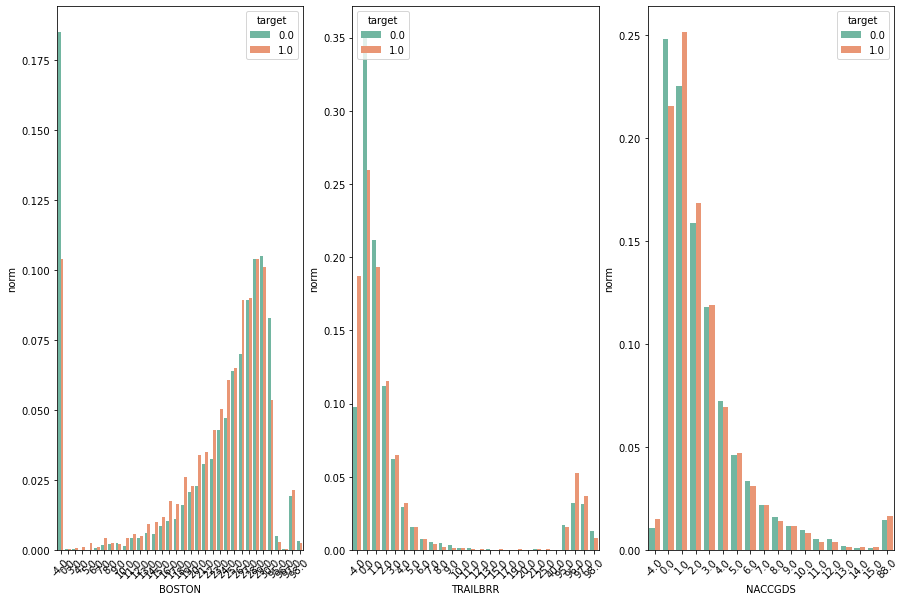

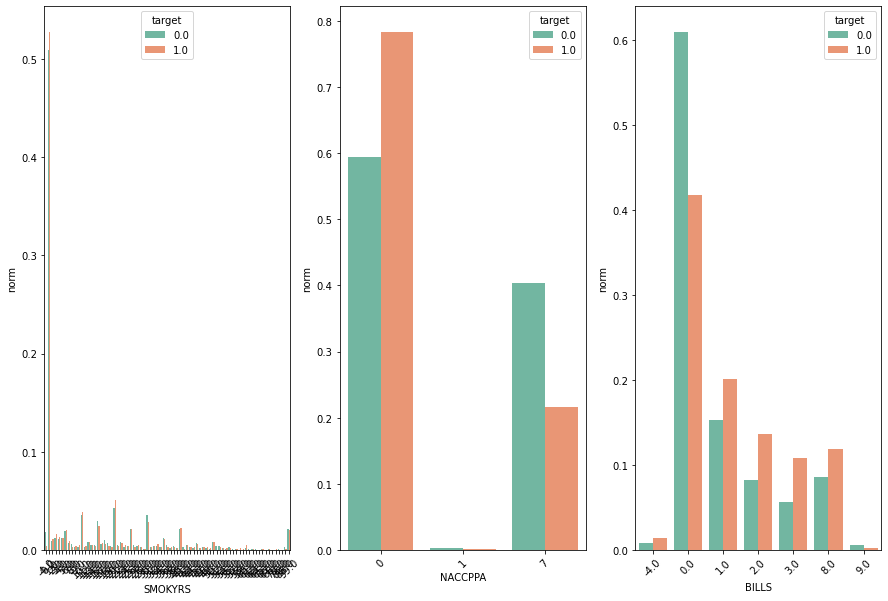

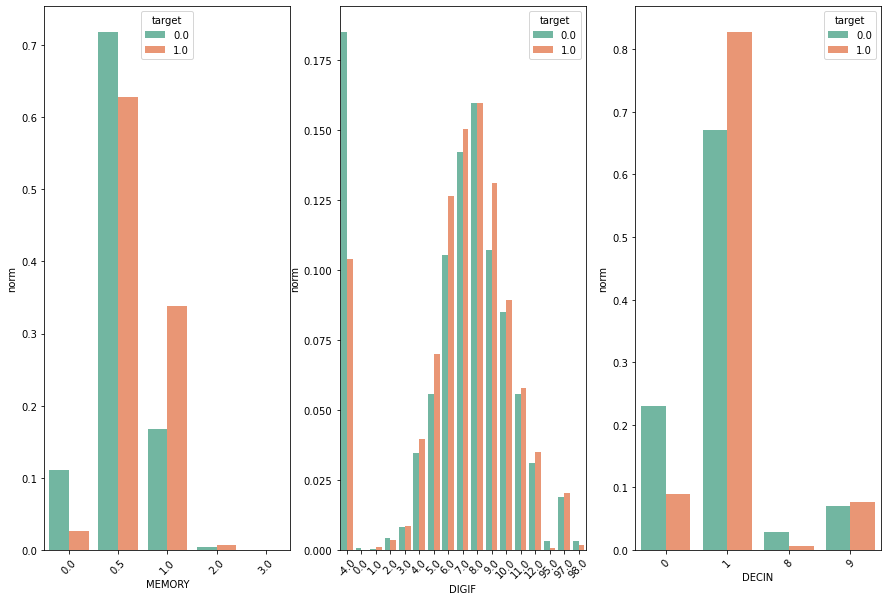

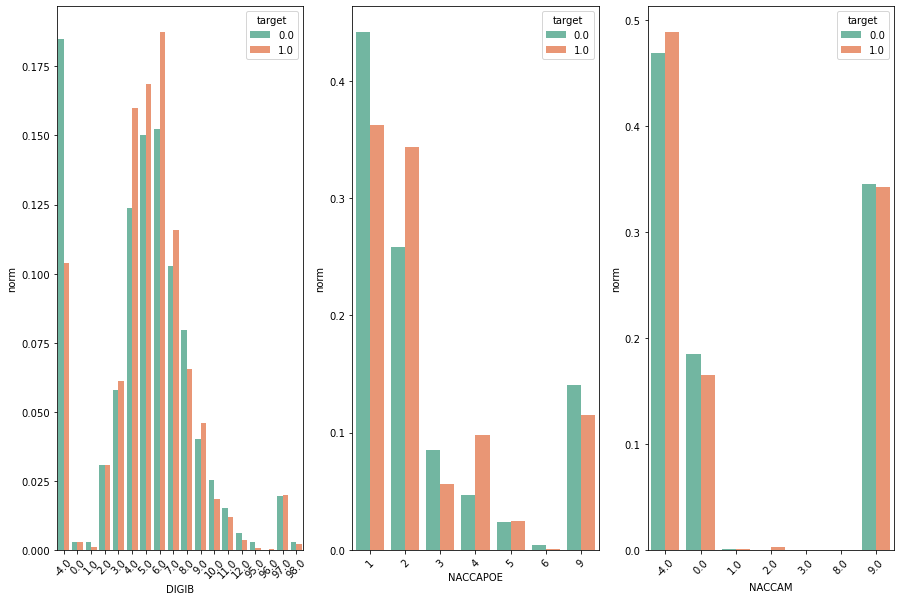

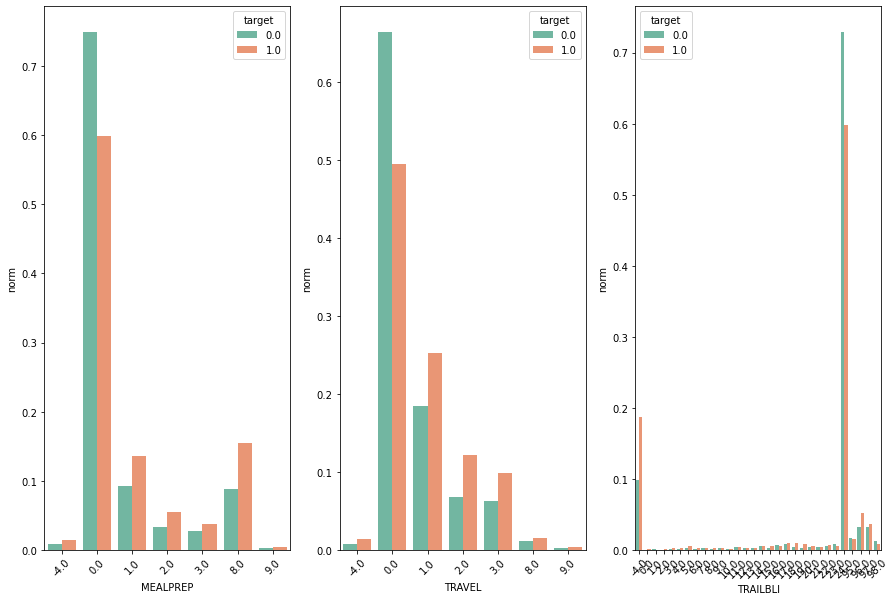

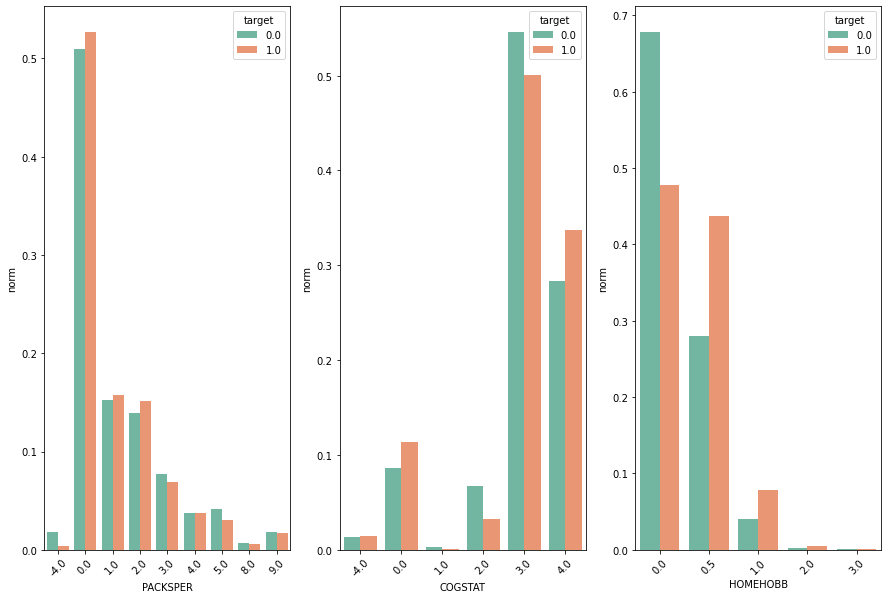

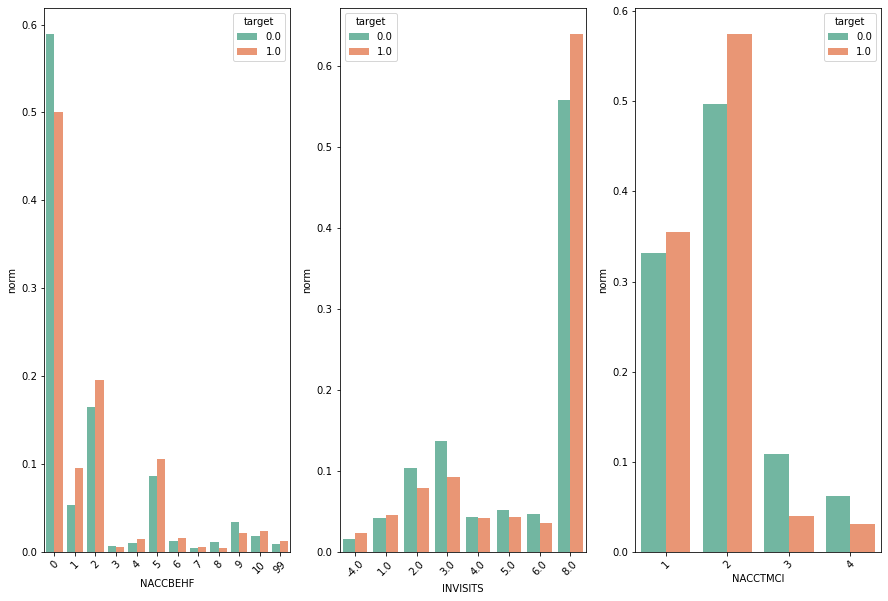

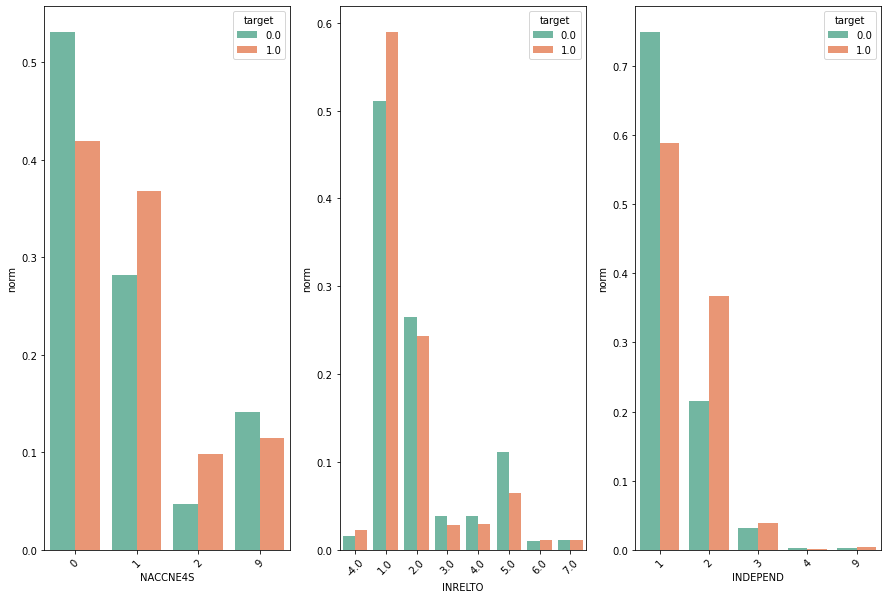

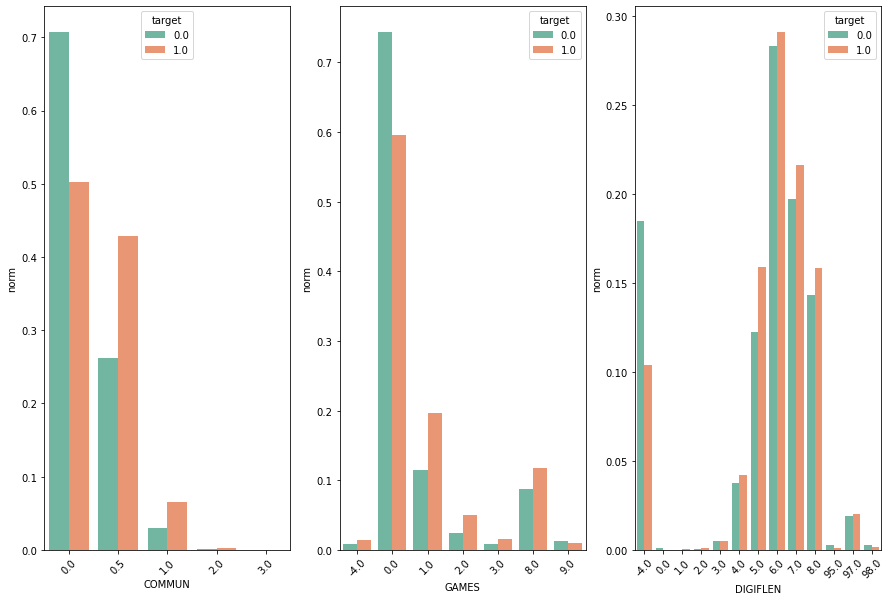

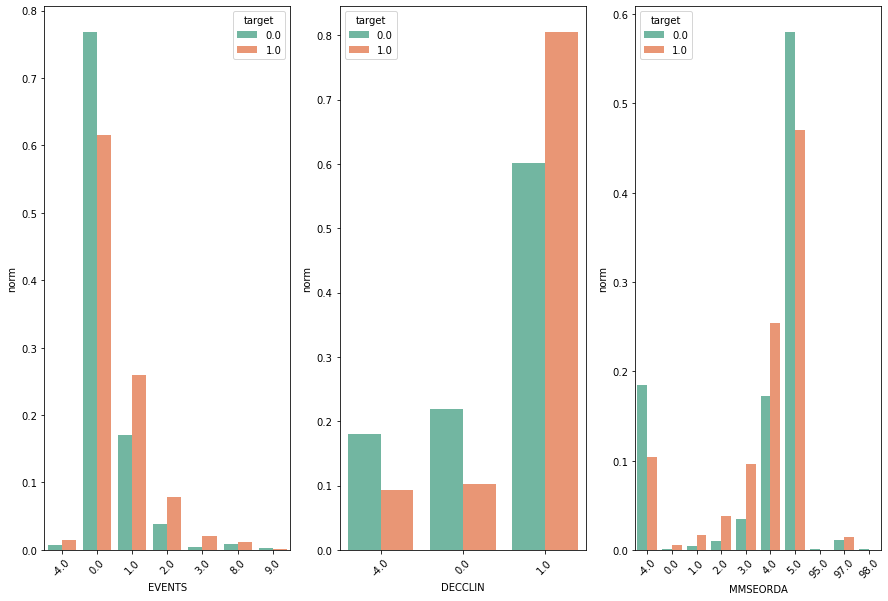

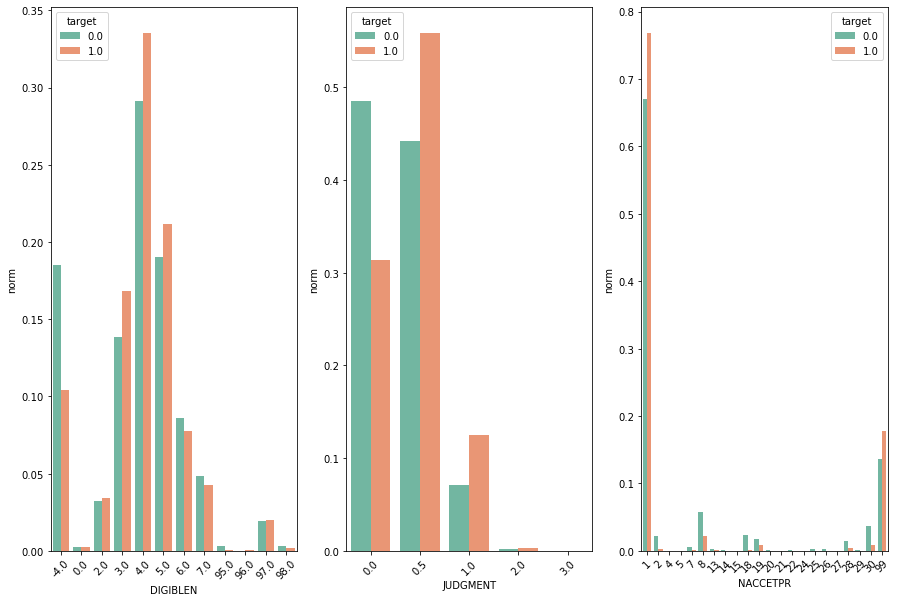

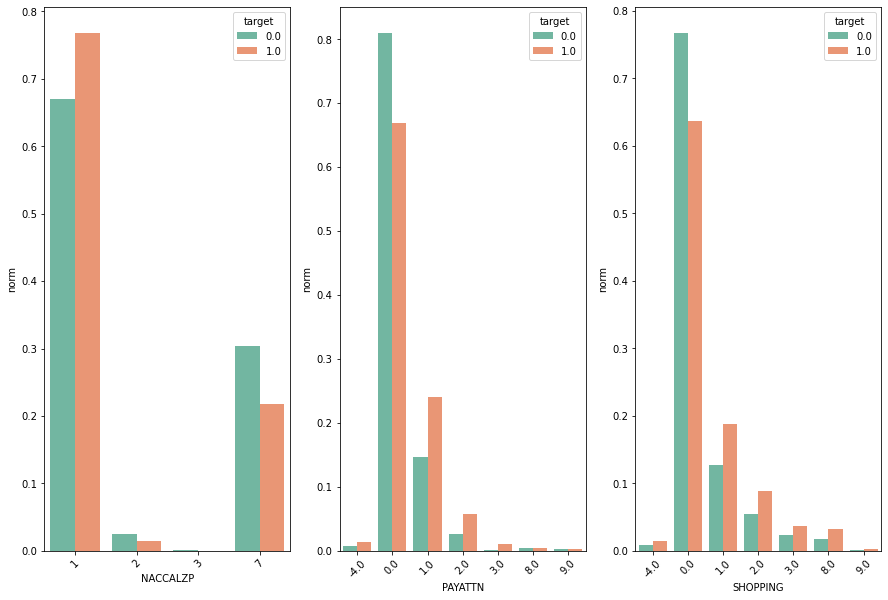

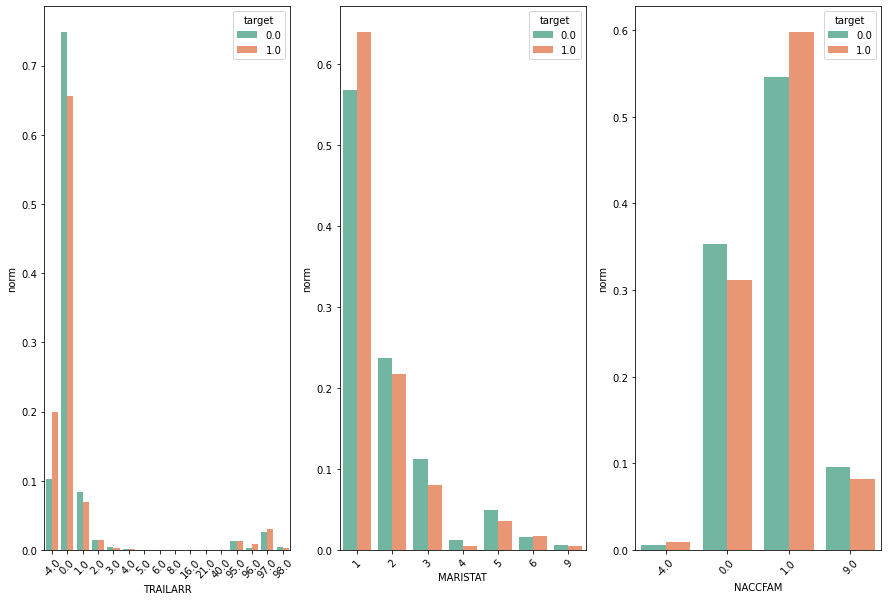

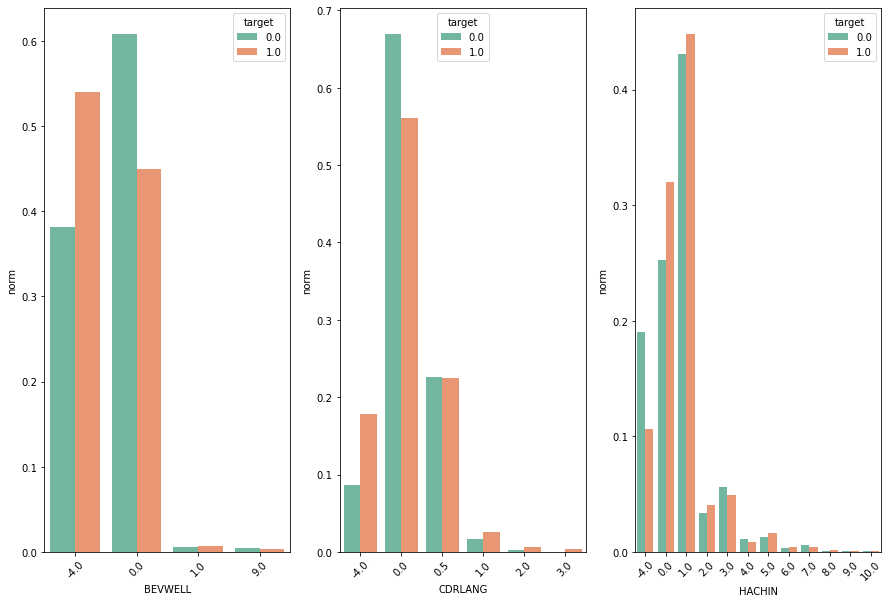

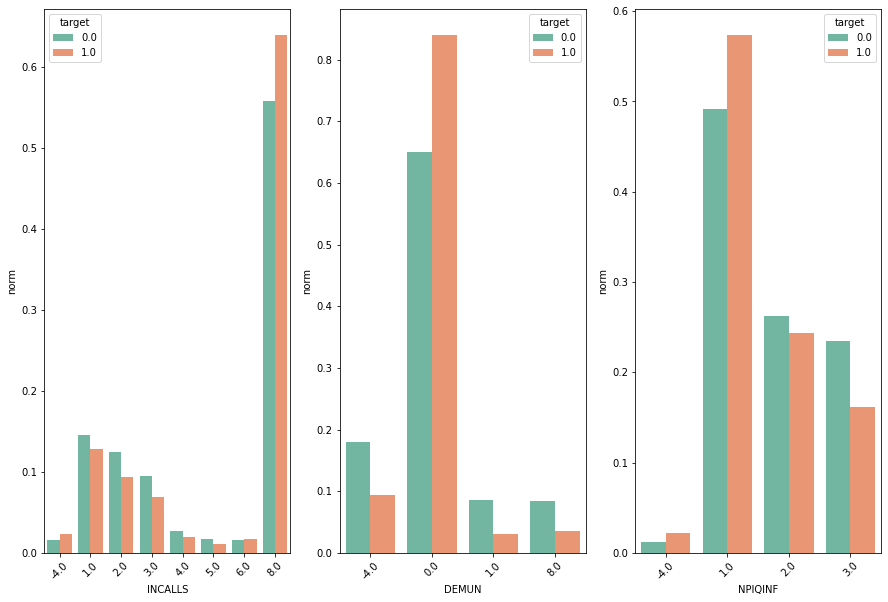

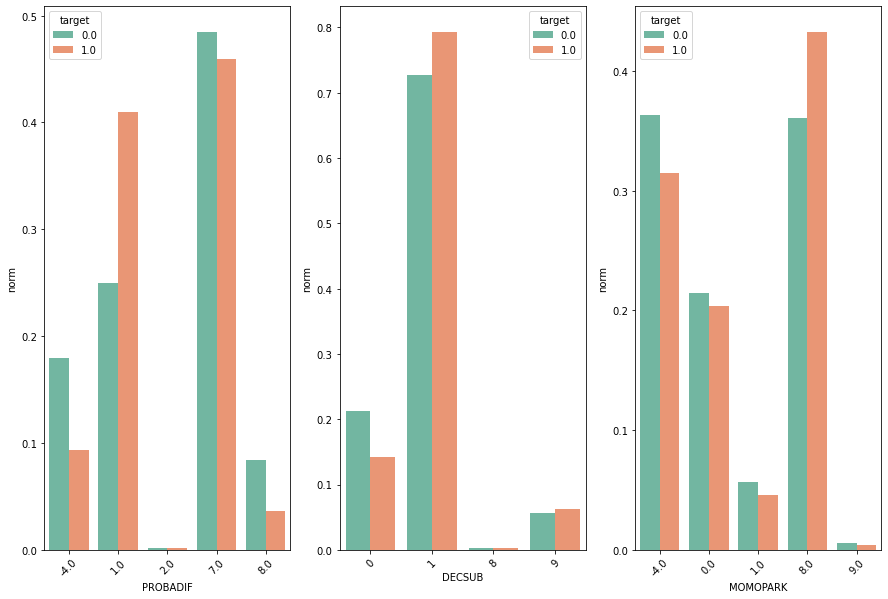

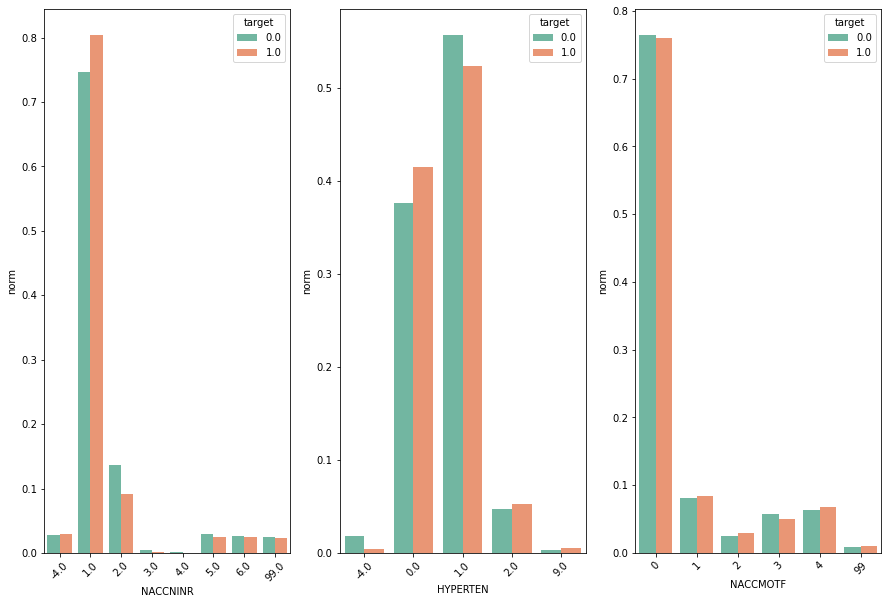

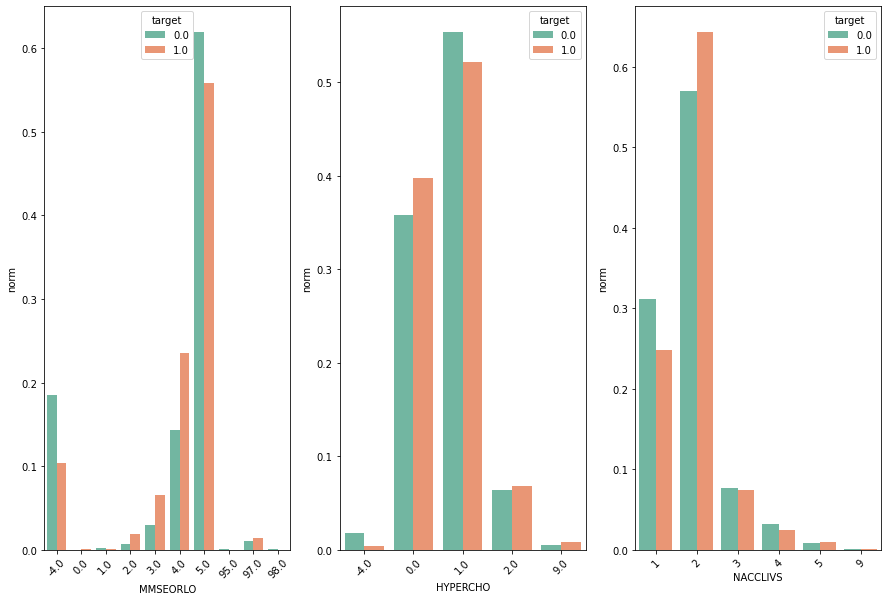

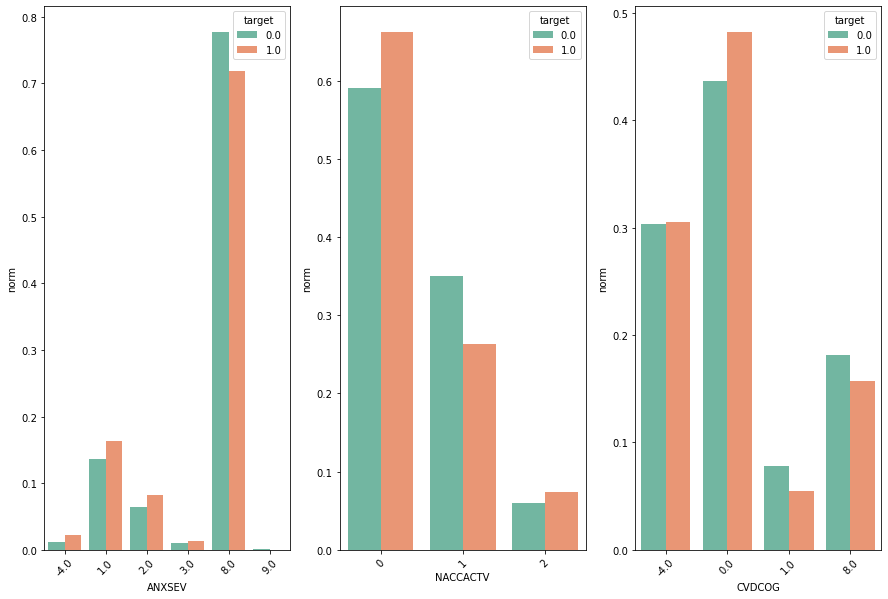

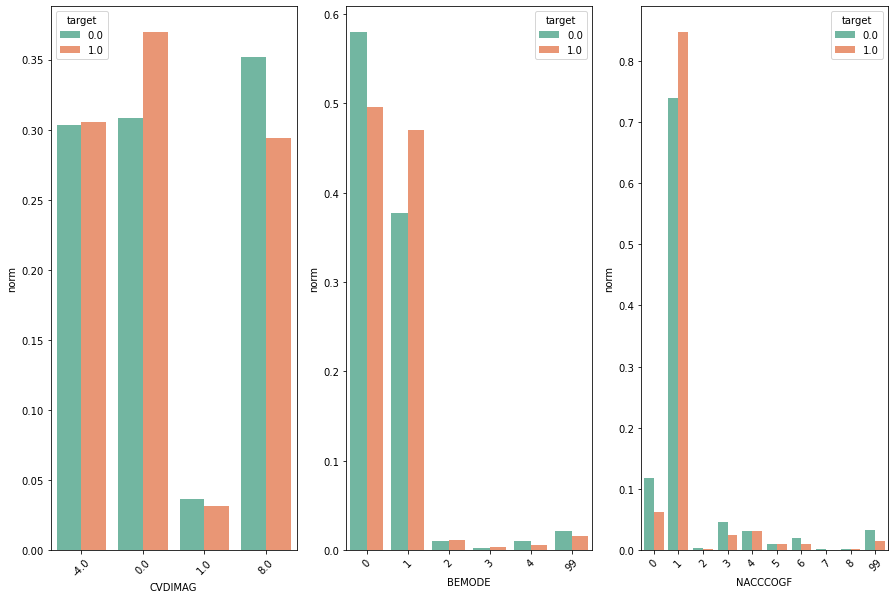

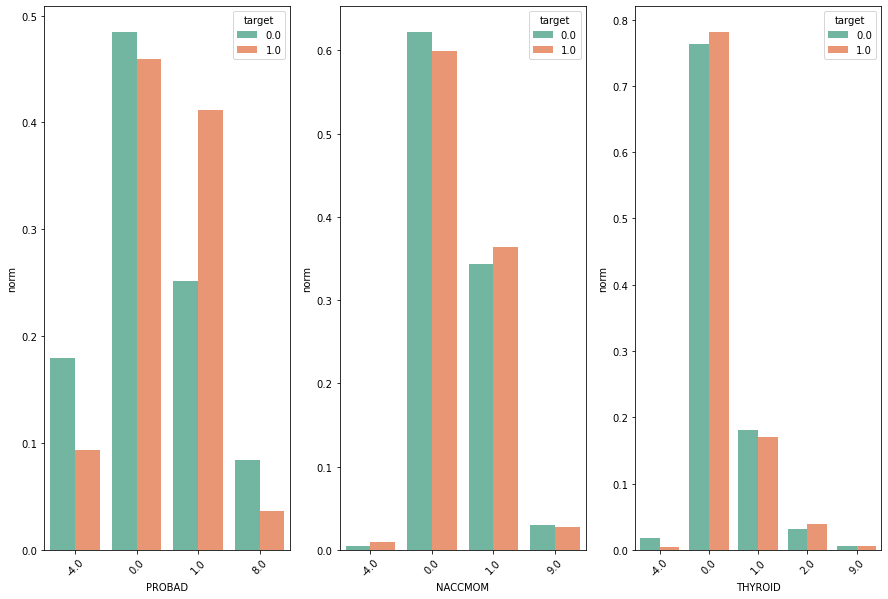

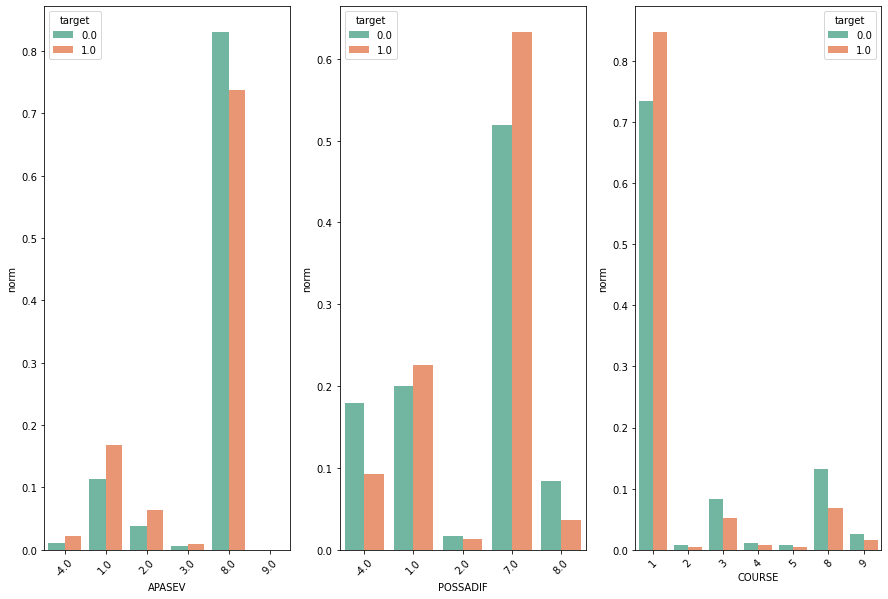

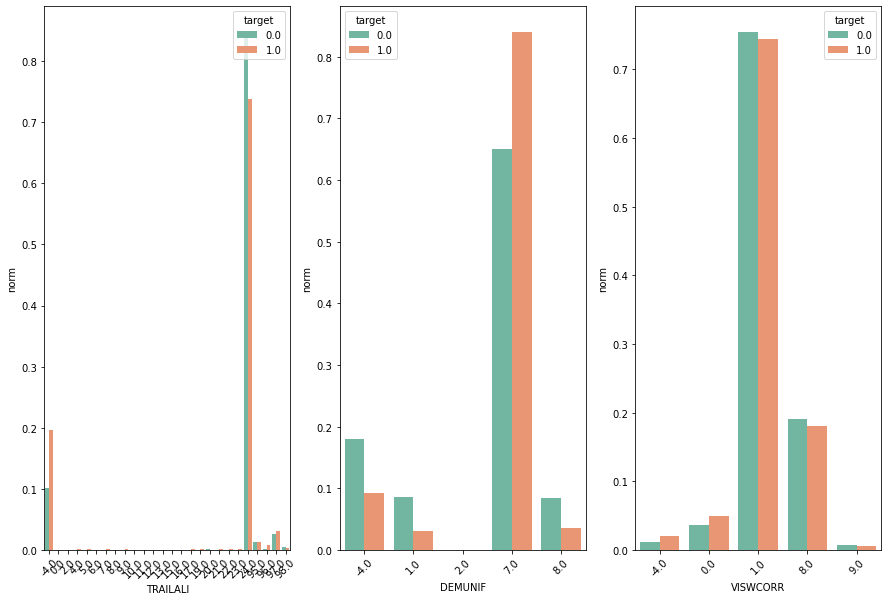

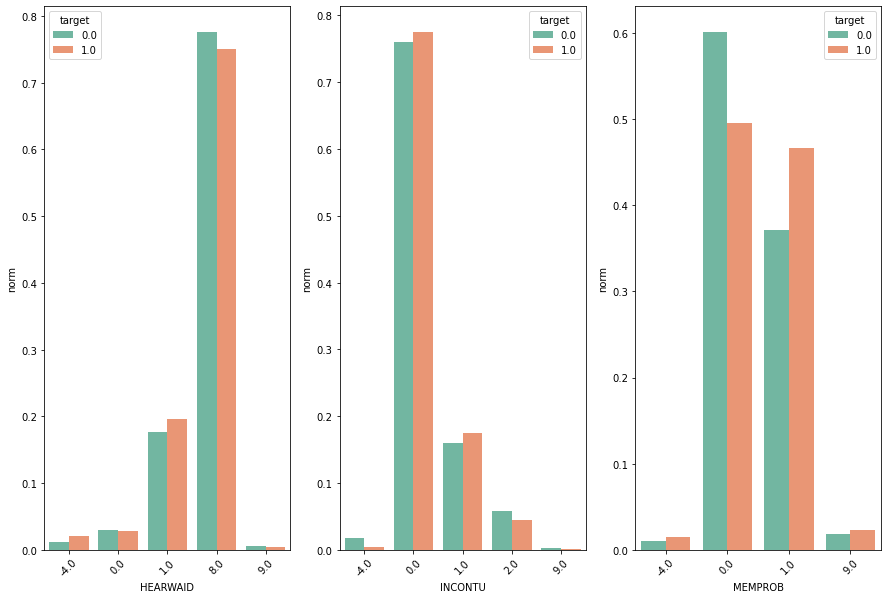

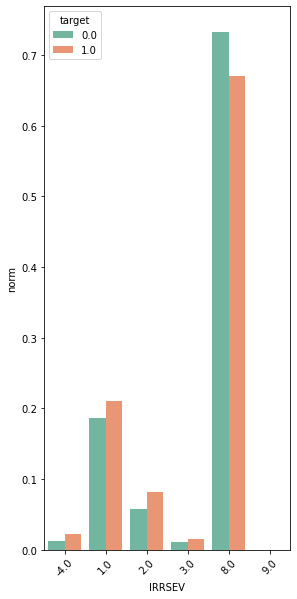

In [23]:
restrict=feat_importances.nlargest(100).index
dfres=res[restrict.to_list()]
temp=dfres.copy()
temp['target']=df['target']
norm_count_group(temp,'target')

Initial production model with 100 features + non-dropped nans

In [24]:
res=df.drop(['NEWINF','target','visit_interval','INBIRYR','HEIGHT'], axis=1)
dfres=res[restrict.to_list()]
X_train, X_test, y_train, y_test = train_test_split(dfres, df['target'], test_size=0.35, random_state=1)

model_feat1 = RandomForestClassifier()
#train model
model_feat1.fit(X_train, y_train)
y_pred = model_feat1.predict(X_test)
print(model_feat1.score(X_test, y_test))
print(precision_score(y_test,y_pred))
print(recall_score(y_test,y_pred))


0.7382830626450116
0.7303206997084548
0.5693181818181818


In [25]:
# save this latest model for now
# pickle.dump(model_feat1, open('../src/models/01prelim_model.sav', 'wb'))
# pickle.dump(restrict, open('../src/features/01prelim_features.sav', 'wb'))

Let's try some threshold changes

ROC AUC=0.795


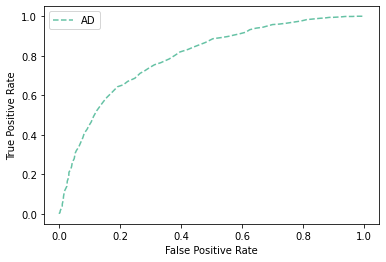

In [26]:
from sklearn.metrics import roc_curve, roc_auc_score
# predict probabilities
probs = model_feat1.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
auc = roc_auc_score(y_test, probs)
# summarize scores
print('ROC AUC=%.3f' % (auc))

# calculate roc curves
fpr, tpr, _ = roc_curve(y_test, probs)
# plot the roc curve for the model
plt.plot(fpr, tpr, linestyle='--', label='AD')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()

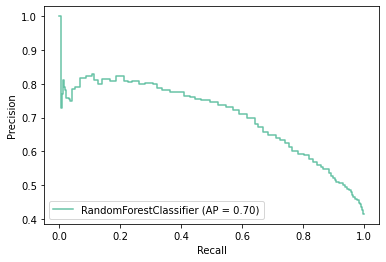

In [27]:
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve
plot_precision_recall_curve(model_feat1, X_test, y_test)

In [28]:
threshold = .45 #to do: youden index?
predicted_proba = model_feat1.predict_proba(X_test)
predicted = (predicted_proba [:,1] >= threshold).astype('int')
print(accuracy_score(y_test, predicted))
print(precision_score(y_test,predicted))
print(recall_score(y_test,predicted))

0.7252900232018561
0.6565217391304348
0.6863636363636364


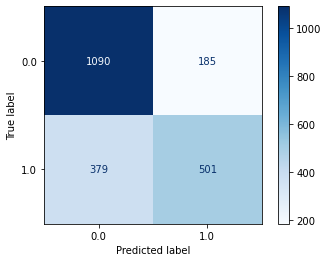

In [29]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(model_feat1, X_test, y_test,cmap=plt.cm.Blues)  

# Model for visit interval: If patient will develop dementia, how long until then

In [30]:
from sklearn.ensemble import RandomForestRegressor
regressor= RandomForestRegressor()

In [31]:
sub=df.loc[df.target==1]
res=sub.drop(['NEWINF','target','INBIRYR','HEIGHT','visit_interval'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(res, sub['visit_interval'], test_size=0.35, random_state=1)
regressor.fit(X_train, y_train)

RandomForestRegressor()

In [32]:
regressor.score(X_test,y_test)

-0.05688327193590581

No signal